![example](images/director_shot.jpeg)

# Microsoft Box Office Insights

**Author:** Jeffrey Hanif Watson
***

## Overview

This project provides a broad overview of the contemporary film industry as well as recommendations with regards to the probable initial capital requirements and film genres that will offer a high probability to maximize profit and return on investment. Descriptive analysis was performed on data obtained from the [The Numbers](https://www.the-numbers.com/), [Rotten Tomatoes](https://www.rottentomatoes.com/), and the [IMDb](https://www.imdb.com/) to arrive at these conclusions. 

## Business Problem

According to data from [The Numbers](https://www.the-numbers.com/), the US box office has increased  from 5.3 billion USD in 1995 to 11.3 billion USD in  2019. Identifying opportunities with the highest probability for profit and ROI in this steadily growing market is the strategic priority. Variables highlighted for analysis include production cost, gross profit, net profit, return on investment, and the ratio of domestic to foreign box office receipts.

## Data Understanding

Data aggregated from [Rotten Tomatoes](https://www.rottentomatoes.com/) provided a solid foundation to analyze overall box office trends, genre trends, and individual films. [IMDb](https://www.imdb.com/) data was better formatted to research actors, directors, writers, and producers. Numerical data from [The Numbers](https://www.the-numbers.com/) was joined with the datasets above to create a data frame of 4,776 films and a complimentary data frame of 32,088 individuals. 

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing utility packages
import datetime
import cpi
import matplotlib.ticker as ticker

%matplotlib inline

# update cpi if flagged out of date
# cpi.update()

A database creation notebook was included with the assignment, so the notebook was run, SQLite was imported, a connection to the database was established, and a cursor and query function were created.

In [3]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query function
def fetcha(q):
    return cur.execute(q).fetchall()

In [4]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

# Data Preparation

Exploratory data analysis and data cleaning was performed on two data frames created by using SQLite to join tables from database. Non-numeric NaNs were converted to strings, date strings were changed to datetime objects, and numeric strings were converted to floats to allow for calculations. Features such as international gross, return on investment (ROI), and gross adjusted for inflation were added as needed for analysis.

## Rotten Tomatoes DF

Due to its comprehensive nature and straightforward layout, the Rotten Tomatoes table, coupled with the financial data from The Numbers, was a more convenient dataset work with when doing analysis on films, genres, and the industry overall. SQLite was employed to join the data tables into a Pandas data frame to facilitate analysis.

### Joining the Tables
Exploration of the column names of each table showed The Numbers `movie` and Rotten Tomatoes `movie_title` columns were the best choices for joining.

In [5]:
# getting the columns from the rotten tomatoes table
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [6]:
# getting the columns from the numbers table
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [7]:
# creating dataframe by joining the numbers and rotten tomatoes tables 
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       """
dfr = pd.DataFrame(fetcha(q))
dfr.columns = [i[0] for i in cur.description]
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

# Data Cleaning

### Missing values were dealt with and datatype conversion was performed.

Checked dataypes and counted null values before cleaning.

In [8]:
# checking datatypes
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   idx                               4776 non-null   int64  
 1   rotten_tomatoes_link              4776 non-null   object 
 2   movie_title                       4776 non-null   object 
 3   movie_info                        4741 non-null   object 
 4   critics_consensus                 4134 non-null   object 
 5   content_rating                    4776 non-null   object 
 6   genres                            4776 non-null   object 
 7   directors                         4724 non-null   object 
 8   authors                           4657 non-null   object 
 9   actors                            4762 non-null   object 
 10  original_release_date             4712 non-null   object 
 11  streaming_release_date            4738 non-null   object 
 12  runtim

In [9]:
# checking for NaN values
dfr.isna().sum()

idx                                   0
rotten_tomatoes_link                  0
movie_title                           0
movie_info                           35
critics_consensus                   642
content_rating                        0
genres                                0
directors                            52
authors                             119
actors                               14
original_release_date                64
streaming_release_date               38
runtime                              35
production_company                   17
tomatometer_status                    3
tomatometer_rating                    3
tomatometer_count                     3
audience_status                      31
audience_rating                      12
audience_count                       13
tomatometer_top_critics_count         0
tomatometer_fresh_critics_count       0
tomatometer_rotten_critics_count      0
idx                                   0
id                                    0


Changed `NaN` name values into `str` objects, date strings into `datetime` objects, and numerical strings into `float` types.

In [10]:
# changing name NaNs to strings
dfr['actors'] = dfr['actors'].fillna('NaN')
dfr['directors'] = dfr['directors'].fillna('NaN')
dfr['authors'] = dfr['authors'].fillna('NaN')
dfr['production_company'] = dfr['production_company'].fillna('NaN')

# changing date strings to datetime objects 
dfr.release_date = pd.to_datetime(dfr.release_date)
dfr['year'] = dfr['release_date'].apply(lambda x: x.year)
dfr['month'] = dfr['release_date'].apply(lambda x: x.month)

#cleaning numerical strings and converting to floats
dfr['worldwide_gross'] = dfr['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['domestic_gross'] = dfr['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['production_budget'] = dfr['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

## Feature Engineering

### Financial analysis columns that seemed likely to be useful in addressing the business problem were added.

International gross and percentage gross from international market columns were added first. Next, net profit and return on investment features were added. Gross, production budget, net profit, and percent gross from international adjusted for inflation columns were also added using the `cpi` package. Finally, the first row of the data frame was checked.

In [11]:
# International gross and percentage gross from international market
dfr['international_gross'] = dfr['worldwide_gross'].sub(dfr['domestic_gross'])
dfr['percent_intl'] = (dfr['international_gross'].divide(dfr['worldwide_gross']))*100

# adding net columns
dfr['domestic_net'] = dfr['domestic_gross'].sub(dfr['production_budget'])
dfr['worldwide_net'] = dfr['worldwide_gross'].sub(dfr['production_budget'])
dfr['international_net'] = dfr['international_gross'].sub(dfr['production_budget'])

# adding roi columns
dfr['domestic_roi'] = dfr['domestic_net'].divide(dfr['production_budget'])*100
dfr['worldwide_roi'] = dfr['worldwide_net'].divide(dfr['production_budget'])*100
dfr['international_roi'] = dfr['international_net'].divide(dfr['production_budget'])*100

# adding adjusted for inflation columns
dfr['adj_dom_gross'] = dfr.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
dfr['adj_ww_gross'] = dfr.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
dfr['adj_i_gross'] = dfr.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
dfr['adj_prod_budg'] = dfr.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)

# adding adjusted net profit columns
dfr['adj_dom_net'] = dfr['adj_dom_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_ww_net'] = dfr['adj_ww_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_i_net'] = dfr['adj_i_gross'].sub(dfr['adj_prod_budg'])

# adding adjusted percentage of gross from international market column
dfr['adj_percent_intl'] = (dfr['adj_i_gross'].divide(dfr['adj_ww_gross']))*100

In [12]:
#checking results
dfr.head(1)

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,worldwide_roi,international_roi,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_percent_intl
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,134.790394,41.350075,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07,60.202665


# A little more cleaning and prep

### Renamed several columns and checked the number of rows.

Checked column names.

In [13]:
# checking column names
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'percent_intl', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_percent_intl'],
      dtype='object')

Renamed several columns for brevity and to make them consistent across data frames.

In [14]:
# renaming columns and checking
dfr = dfr.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top',\
                            'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'percent_intl', 'domestic_net',
       'worldwide_net', 'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_percent_intl'],
      dtype='object')

Checked number of rows.

In [15]:
dfr.shape

(4776, 48)

### Created a Rotten Tomatoes genre list and function to count genre tags.

In [16]:
# creating rt genre list
split_list = []
for genre in dfr.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))

In [17]:
# creating function to count genres tags

def genre_count(DF, genre_list):
    """accepts a data frame and list of genres
    and returns a list consisting of a genre list and a list of counts"""
    counts = []
    for genre in genre_list:
        count = DF.genres.str.contains(genre, case=False).sum()
        counts.append(count)
    return ([genre_list, counts])

# IMDb DF

The structure and indexing of The Internet Movie Database (IMDb) data tables made them easier to work with when analyzing the creative talent side of the industry. Individuals each had their own row and unique code that could be cross-referenced with  unique movie codes.  Data prep, cleaning and feature engineering were very similar for the IMDb dataframe. The primary differences were that the SQL database schema was used to decide on the join columns, and a custom function was created to adjust columns for inflation. Finally, an IMDb genre list was created.

## Creating the data frame with SQL

In [18]:
# creating talent dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
dfi = pd.DataFrame(fetcha(q))
dfi.columns = [i[0] for i in cur.description]   

## A little exploration and prep on the columns.

Checked datatypes, renamed some columns, and dropped extraneous ones.

In [19]:
# checking columns and dtypes
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [20]:
# renaming columns and dropping extraneous columns
dfi = dfi.drop(['idx', 'birth_year', 'death_year', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
dfi = dfi.rename(columns = {'movie':'title', 'release_date':'date'})

Checked for `Nan` values and performed the same cleaning routine as in the Rotten Tomatoes data frame.

In [21]:
# checking numbers of NaNs
dfi.isna().sum()

nconst                 0
primary_name           0
tconst                 0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [22]:
# changings NaNs to strings
dfi['genres'] = dfi.genres.fillna('NaN')

#cleaning numerical strings and converting to floats
dfi['worldwide_gross'] = dfi['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['domestic_gross'] = dfi['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['production_budget'] = dfi['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

# changing date string to datetime object 
dfi.date = pd.to_datetime(dfi.date)
dfi['year'] = dfi['date'].apply(lambda x: x.year)
dfi['month'] = dfi['date'].apply(lambda x: x.month)

## Feature engineering

A custom function was required to ignore entries that contained dates in 2020 while applying `cpi.inflate()`. Inflation data for 2020 was unavailable in `cpi` at time the notebook was created which led to errors.

In [23]:
# defining function to adjust for inflation because the year
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    """accepts a row and column name and checks
    if the year of the row is 2020. If the year is not 2020,
    a value adjusted for inflation is returned. If the year is 2020,
    the original value is returned"""
    
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

An international gross feature was created as well as adjusted gross, net, and ROI columns. Checked the first row.

In [24]:
# creating intl gross column
dfi['international_gross'] = dfi['worldwide_gross'].sub(dfi['domestic_gross'])

#adding adjusted budget and gross profit columns
dfi['adj_prod_budg'] = dfi.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
dfi['adj_dom_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
dfi['adj_ww_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
dfi['adj_i_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

#adding net profit columns
dfi['adj_dom_net'] = dfi['adj_dom_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_ww_net'] = dfi['adj_ww_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_i_net'] = dfi['adj_i_gross'].sub(dfi['adj_prod_budg'])

#adding return on investment columns and checking results
dfi['dom_roi'] = dfi['adj_dom_net'].divide(dfi['adj_prod_budg'])
dfi['ww_roi'] = dfi['adj_ww_net'].divide(dfi['adj_prod_budg'])
dfi['i_roi'] = dfi['adj_i_net'].divide(dfi['adj_prod_budg'])
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,dom_roi,ww_roi,i_roi
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,...,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08,-1.562365e+07,1.434927e+08,9.653712e+07,-0.249662,2.292976,1.542638


Checked number of rows.

In [25]:
dfi.shape

(32406, 23)

### Checked job titles.

In [26]:
# getting job titles
dfi.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

### Created IMDb genre list.

In [27]:
# creating imdb genres list
split_list = []
for genre in dfi.genres:
    split_list += [g.strip() for g in genre.split(',')]
genres_i = list(set(split_list))

### Notebook styling

In [28]:
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='winter_r')

# Budget Data Analysis

Estimated the projected cost of the first year's films. First, found the mean budget of all film released since 2009. Next, found the top one-hundred production companies and formed a data frame of the top six companies. Using the average production budget of a film released by a top six studio over the years from 2009 to 2019, estimated the corresponding marketing budget. Finally, estimated the total cost for first fifteen films to be **1,588,954,478 USD**.

## Initial Work

Found mean and median production budgets for all films released since 2009 in data set.

In [29]:
post_2008 = dfr[dfr.year >= 2009]
print(post_2008.production_budget.mean())
post_2008.production_budget.median()

43193820.72004186


22500000.0

Found Top 100 Production Companies

In [30]:
top100_pcs = dfr.groupby(['production_company'])\
                                    .worldwide_gross.sum()\
                                    .sort_values(ascending=False).head(100) 
top100_pcs = pd.DataFrame(top100_pcs)

Created list of the top six production companies, and made a top six production companies data frame.

In [31]:
top6_pc = list(top100_pcs.head(6).index)
pc_df = dfr[dfr.production_company.isin(top6_pc)]

Found median and mean production budgets for films released by top six companies.

In [32]:
print(pc_df.production_budget.mean())
pc_df.production_budget.median()

55966435.00276243


40000000.0

Found median and mean budgets for films released by top six companies after 2008. Used this mean in the total cost calculation.

In [33]:
post_2008 = pc_df[pc_df.year >= 2009]
mean_prod = post_2008.production_budget.mean()
print(post_2008.production_budget.median())
print('Mean Budget for a Post-2008 Film:', mean_prod)

45000000.0
Mean Budget for a Post-2008 Film: 70620199.04458599


Estimated mean marketing budget for a film. An industry rule of thumb for marketing budgets is about half of the production budget, so that was used for the estimate.

In [34]:
market_budg = mean_prod/2
market_budg

35310099.522292994

In [35]:
total_film_cost = mean_prod + market_budg
total_film_cost

105930298.56687897

According to data from [The Numbers](https://www.the-numbers.com/), the average number of films released by a major (top six) studio is about fifteen.

In [36]:
# film count per year for top six studios 2009-2019 
film_counts = [111, 96, 101, 90, 78, 88, 93, 95, 81, 86, 87]
mean_num_films = sum(film_counts)/(6*len(film_counts))
mean_num_films

15.242424242424242

### Estimated total cost for first year's slate of fifteen films: **1,588,954,478 USD**.

Using the information found above, caluculated the projected cost of the first fifteen films

In [37]:
# first year's cost 
15*(mean_prod + market_budg)

1588954478.5031846

## Correlation Between Production Budget and Worldwide Gross

Plotted Budget vs Worldwide Gross for films released by the top six companies from 2009 to 2019 and found a positive correlation between them.

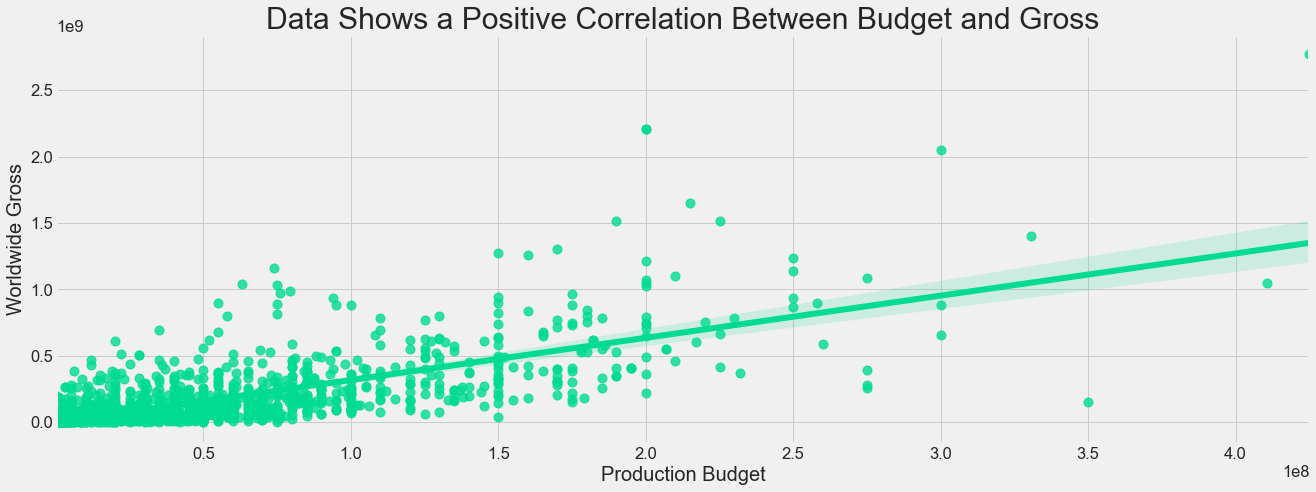

In [38]:
fig, ax=plt.subplots(figsize=(20,7))
sns.regplot(x="production_budget", y="worldwide_gross", data=pc_df)
ax.set_xlabel("Production Budget", size=20)
ax.set_ylabel("Worldwide Gross", size=20) 
ax.set_title("Data Shows a Positive Correlation Between Budget and Gross", size=30)
# plt.savefig('33_budget_vs_gross',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

## Top Six Studio Budget Trends

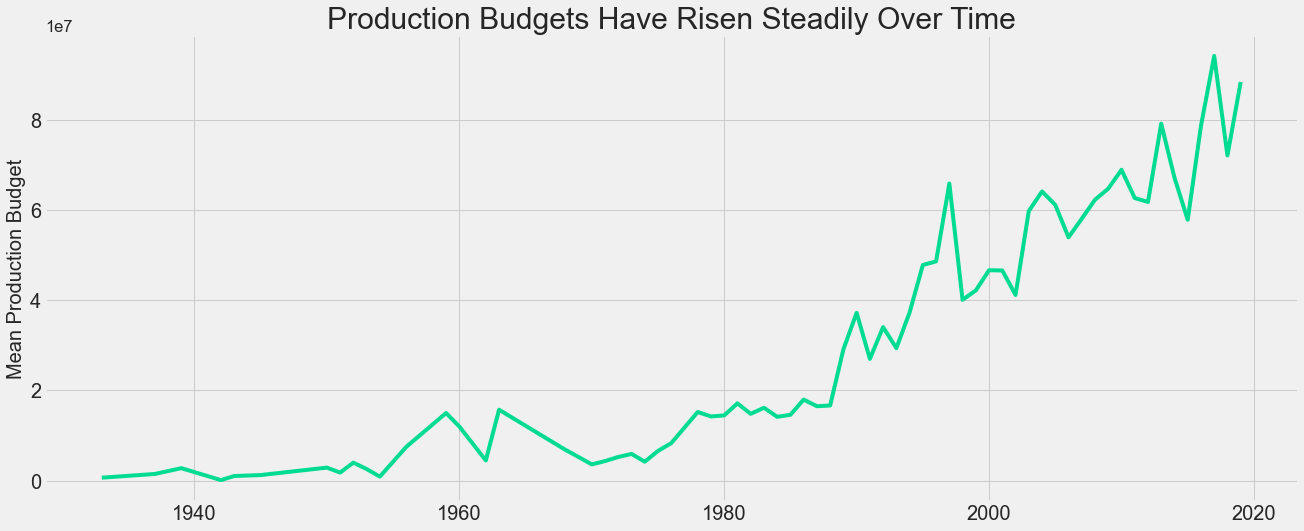

In [48]:
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x='year', y='production_budget', data=pc_df, ci=None)
ax.tick_params(labelsize=20) 
ax.set_xlabel("")
ax.set_ylabel("Mean Production Budget", size=20) 
ax.set_title( "Production Budgets Have Risen Steadily Over Time", size=30)
# plt.savefig('34_average_budgets',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

# Top 100 Films by Worldwide Gross

Explored the top grossing films looking for trends in the data and created visualizations to expedite the analysis. Created a preliminary data frame, dropped duplicate titles, and sorted by worldwide gross. Created a movie count by year data frame and graphed the results.

In [49]:
# creating dataframes sorted by gross
title_gross = dfr[['title', 'production_budget', 'domestic_gross', 'worldwide_gross',\
                   'international_gross', 'worldwide_net', 'worldwide_roi',\
                   'percent_intl', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross',\
                                                     ascending=False).head(100)
top10_gross_films = unique_gross_titles.sort_values(by='worldwide_gross',\
                                                    ascending=False).head(10)

#  getting count by year
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})

Looked at the distribution by year of the top one hundred grossing films and found that most of the films were released after 2008.

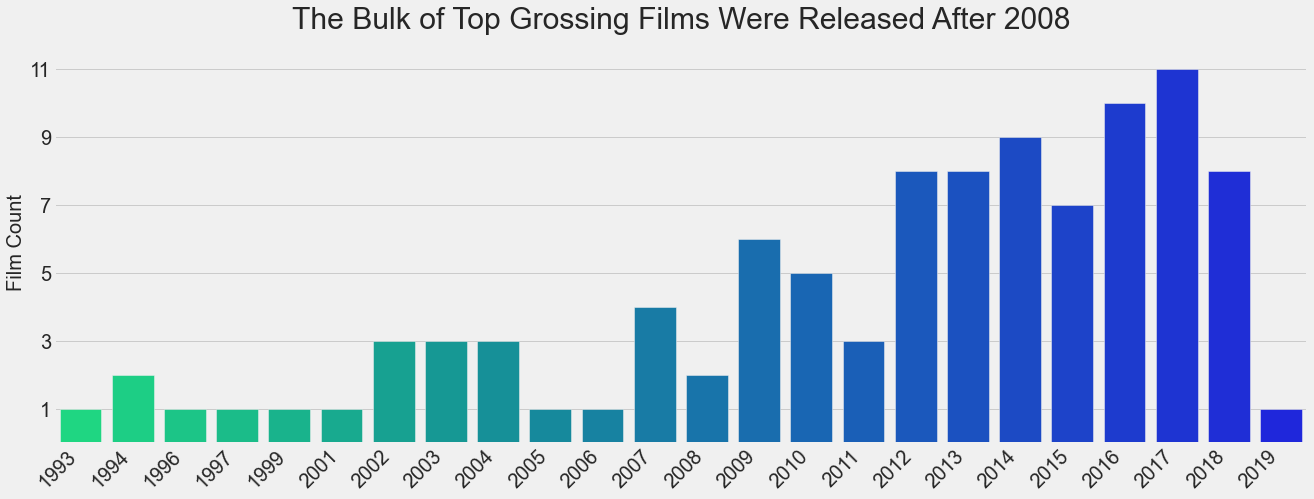

In [50]:
fig, ax= plt.subplots(figsize=(20,7))
ax = sns.barplot(x='year', y= 'count', data=t100_count_by_year, palette='winter_r')
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 12), yticks=[1, 3, 5, 7, 9, 11])
ax.tick_params(labelsize=20) 
ax.set_xlabel("", size = 20)
ax.set_ylabel("Film Count ", size = 20) 
ax.set_title( "The Bulk of Top Grossing Films Were Released After 2008" , size = 30 )
# plt.savefig('1_100_grossing_films',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

Graphing production budgets over time showed a strong upward trend in the data.

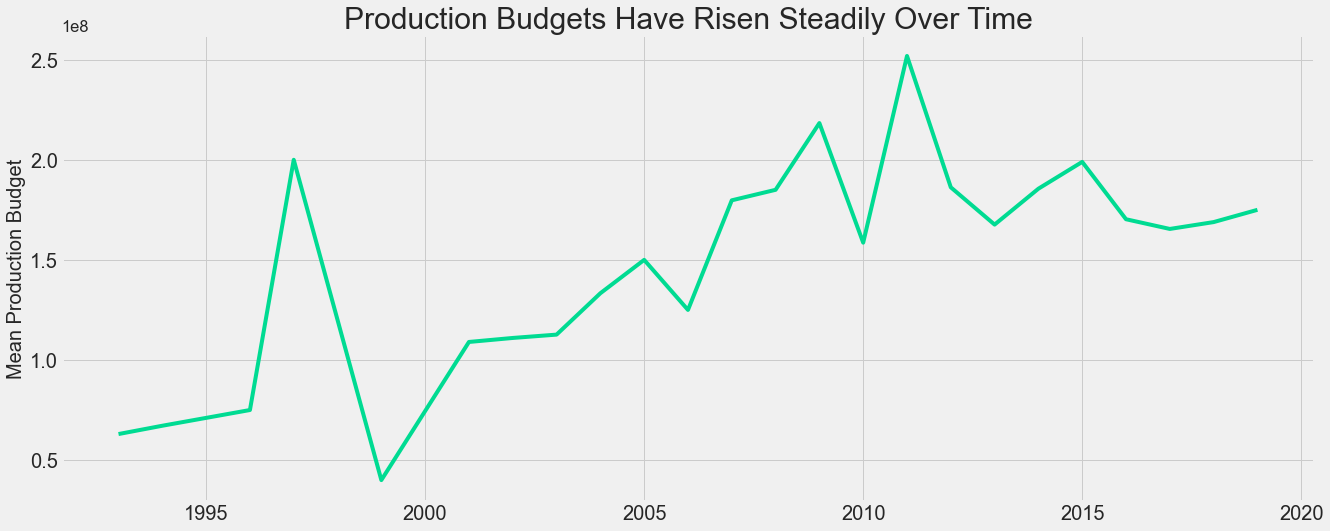

In [51]:
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ci=None)
ax.tick_params(labelsize=20) 
ax.set_xlabel("")
ax.set_ylabel("Mean Production Budget", size=20) 
ax.set_title( "Production Budgets Have Risen Steadily Over Time", size=30)
# plt.savefig('2_average_budgets',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

Graphing the distributions of the budget, gross, and return on investment revealed various degrees of rightward skew in each. Several very expensive and sucessful outliers are tweaking the distributions.

In [52]:
medians = [top100_gross_films.production_budget.median(),\
          top100_gross_films.worldwide_gross.median(),\
          top100_gross_films.worldwide_roi.median()]
medians

[172500000.0, 879423029.0, 451.34287125]

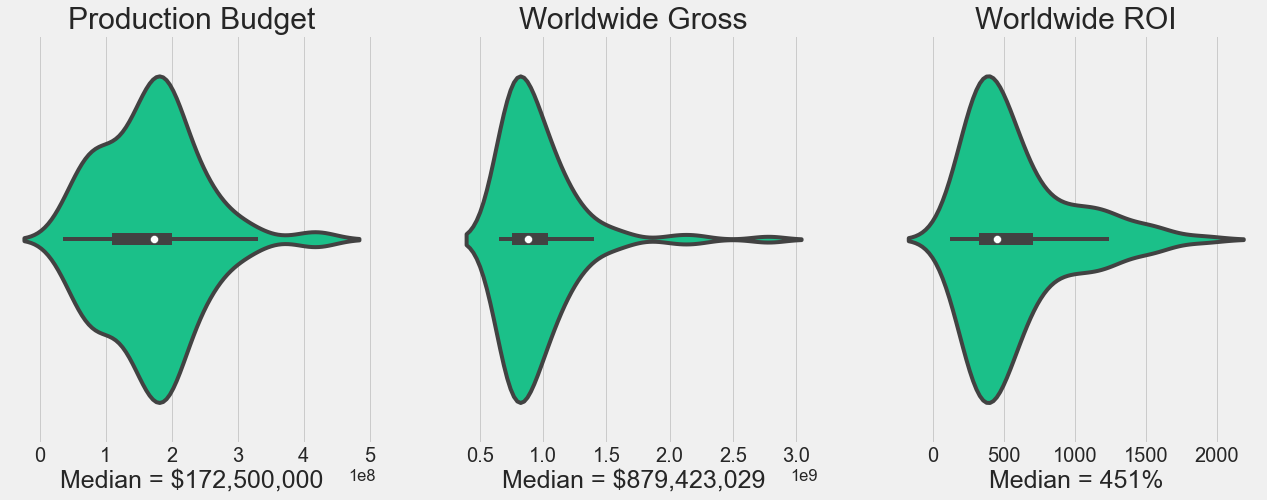

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=top100_gross_films)
sns.violinplot(ax=ax2, x='worldwide_gross', data=top100_gross_films)
sns.violinplot(ax=ax3, x='worldwide_roi', data=top100_gross_films)
ax1.set_title('Production Budget', size = 30)
ax2.set_title('Worldwide Gross', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $172,500,000', size=25)
ax2.set_xlabel('Median = $879,423,029', size=25)
ax3.set_xlabel('Median = 451%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('3_100_gross_stats_slim',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

Looked at the basic statistics to the data frame.

In [54]:
# top 100 by gross basic stats
top100_gross_films.describe()

,production_budget,domestic_gross,worldwide_gross,international_gross,worldwide_net,worldwide_roi,percent_intl,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,1.685750e+08,3.409426e+08,9.576570e+08,6.167144e+08,7.890820e+08,584.638778,63.944459,2011.340000,7.250000
std,7.397127e+07,1.230460e+08,3.273300e+08,2.479270e+08,3.019174e+08,368.824404,8.550096,6.067333,2.903759
min,3.500000e+07,1.595559e+08,6.522201e+08,2.699127e+08,3.559452e+08,118.648403,39.814630,1993.000000,2.000000
25%,1.100000e+08,2.575551e+08,7.578371e+08,4.667287e+08,6.014434e+08,323.640428,58.218483,2009.000000,5.000000
50%,1.725000e+08,3.236558e+08,8.794230e+08,5.530922e+08,7.003720e+08,451.342871,64.049093,2013.000000,6.000000
75%,2.000000e+08,4.025105e+08,1.040525e+09,6.906684e+08,8.783895e+08,702.984598,70.182428,2016.000000,11.000000
max,4.250000e+08,7.605076e+08,2.776345e+09,2.015838e+09,2.351345e+09,1892.737054,81.717176,2019.000000,12.000000


Created a data frame to visualize the domestic vs international shares of the worldwide gross and found the bulk of the gross is earned outside of the US.

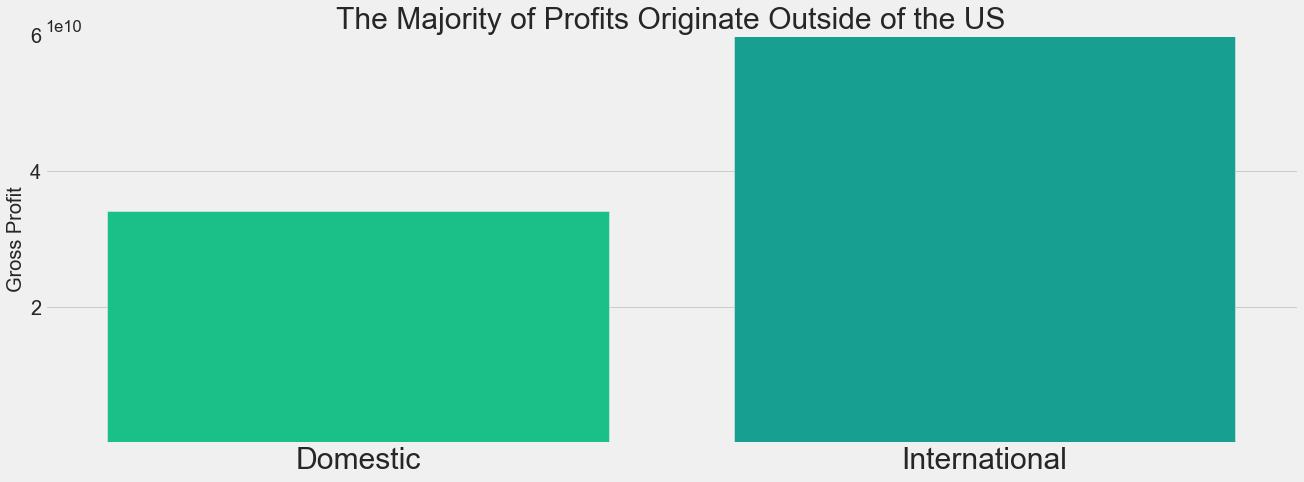

In [55]:
dom = top100_gross_films.domestic_gross.sum()
intl = top100_gross_films.international_gross.sum()
dvsi = pd.DataFrame({'type': ['Domestic', 'International'], 'values': [dom, intl]})
fig, ax=plt.subplots(figsize=(20,7))
ax = sns.barplot(x='type', y='values', data=dvsi)
ax.set(ylim=[0, 1*10**10], yticks=[2*10**10, 4*10**10, 6*10**10])
ax.set_xlabel("")
ax.set_ylabel("Gross Profit", size=20)
ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("The Majority of Profits Originate Outside of the US", size=30)
# plt.savefig('4_domestic_international',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

Checked the trend over time and saw that the percentage of the gross from outside the US is consistently between 50% and 75%.

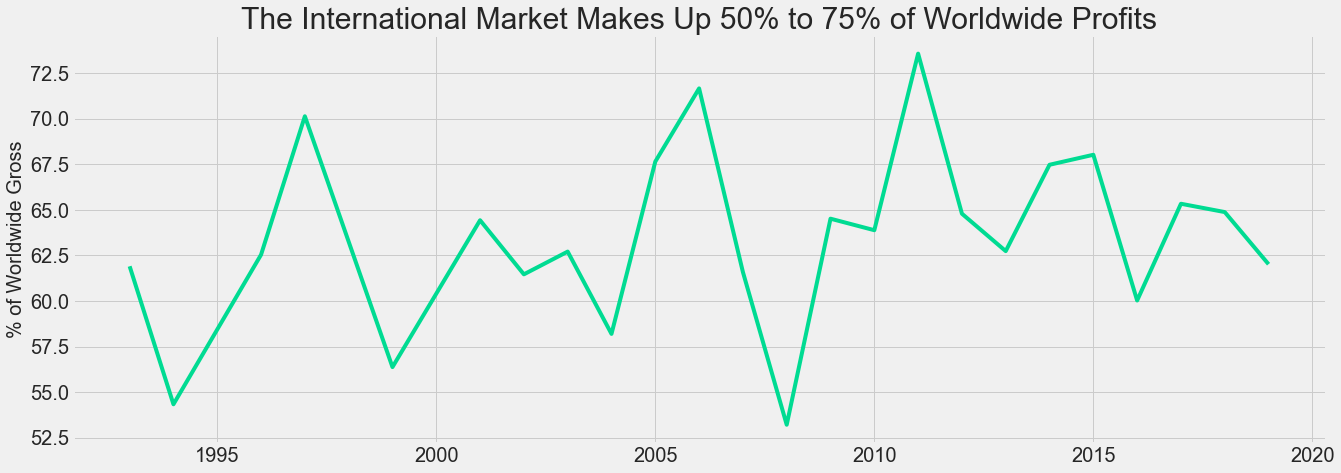

In [56]:
fig, ax = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x='year', y='percent_intl', data=top100_gross_films, ci=None)
ax.tick_params(labelsize=20) 
ax.set_xlabel("")
ax.set_ylabel("% of Worldwide Gross", size=20) 
ax.set_title( "The International Market Makes Up 50% to 75% of Worldwide Profits", size=30)
# plt.savefig('5_percent_international',  bbox_inches ="tight", pad_inches = .25,\
#             transparent = False)
plt.show()

### The Big Five

Created a data frame, checked the genre counts of the top 100, and found *The Big Five*: **Action, Scifi, Drama, Family, and Comedy**.

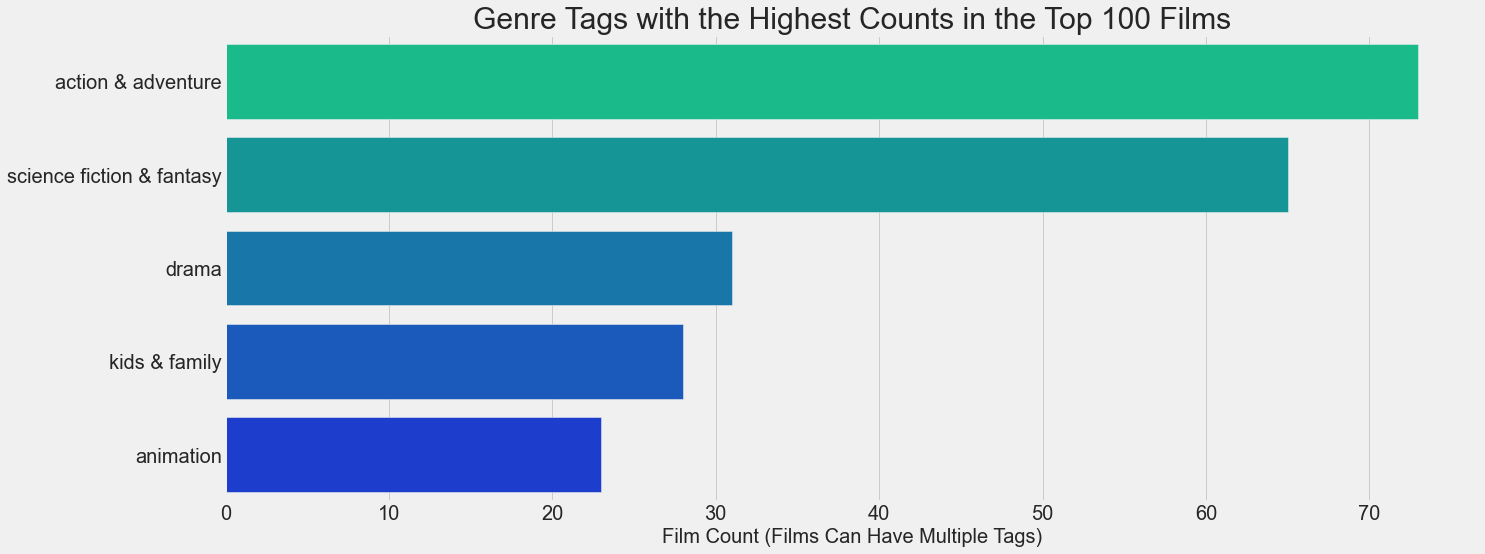

In [57]:
# top gross genres; there are overlaps because a film can have multiple genres
gross_genres = genre_count(top100_gross_films, genres)
top_g_genres = pd.DataFrame()
top_g_genres['Genre'] = gross_genres[0]
top_g_genres['Count'] = gross_genres[1]
top_g_genres = top_g_genres.sort_values(by='Count', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='Count', y='Genre', data=top_g_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count (Films Can Have Multiple Tags)", fontsize=20)
ax.set_ylabel("")
ax.set_title("Genre Tags with the Highest Counts in the Top 100 Films", fontsize=30)
# plt.savefig('6_100_genre_counts',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

Plotted the Top 10 Films by Gross.

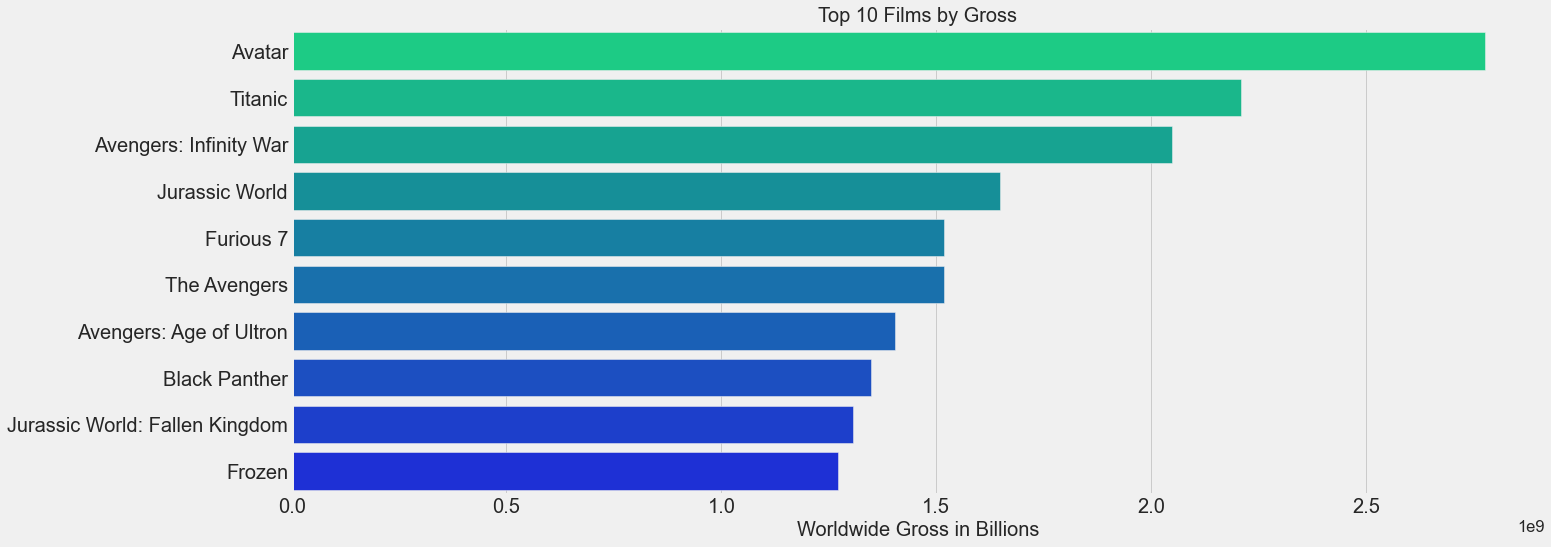

In [225]:
# plotting top 10 films by gross
fig, ax=plt.subplots(figsize=(20, 8))
sns.barplot(x='worldwide_gross', y='title', data= top10_gross_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Worldwide Gross in Billions", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top 10 Films by Gross', size=20)
# plt.savefig('7_20_by_gross',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

# Top ROI Genres & Films

## The Hidden Value Genres

Explored the top return on investment films looking for trends in the data and created visualizations to expedite the analysis. Created a preliminary data frame, dropped duplicate titles, and sorted by worldwide ROI. Created a genre count data frame, graphed the results, and identifed the *Hidden Value* genres with the highest return on investment: **Drama, Horror, and Comedy**. (Note that Drama and Comedy are also members of the Big Five)

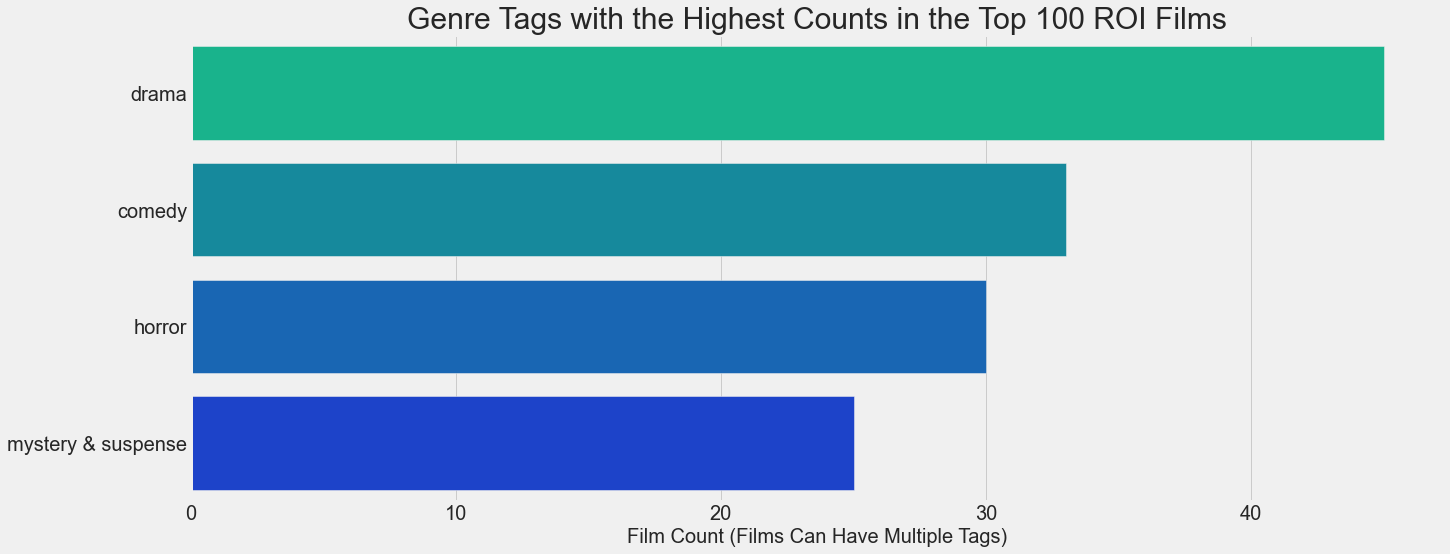

In [226]:
title_roi = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_titles = title_roi.drop_duplicates(subset = ['title'])
top20_roi_films = unique_titles.sort_values(by='worldwide_roi', ascending=False).head(20)
top100_roi_films = unique_titles.sort_values(by='worldwide_roi', ascending=False).head(100)

# top ROI genres; there are overlaps because a film can have multiple genres
roi_genres = genre_count(top100_roi_films, genres)
top_r_genres = pd.DataFrame()
top_r_genres['Genre'] = roi_genres[0]
top_r_genres['Count'] = roi_genres[1]
top_r_genres = top_r_genres.sort_values(by='Count', ascending=False).head(4)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='Count', y='Genre', data=top_r_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count (Films Can Have Multiple Tags)", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genre Tags with the Highest Counts in the Top 100 ROI Films", fontsize=30)
# plt.savefig('8_top_roi_genres',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

Plotted the highest ROI films of the top 100 grossing films. 

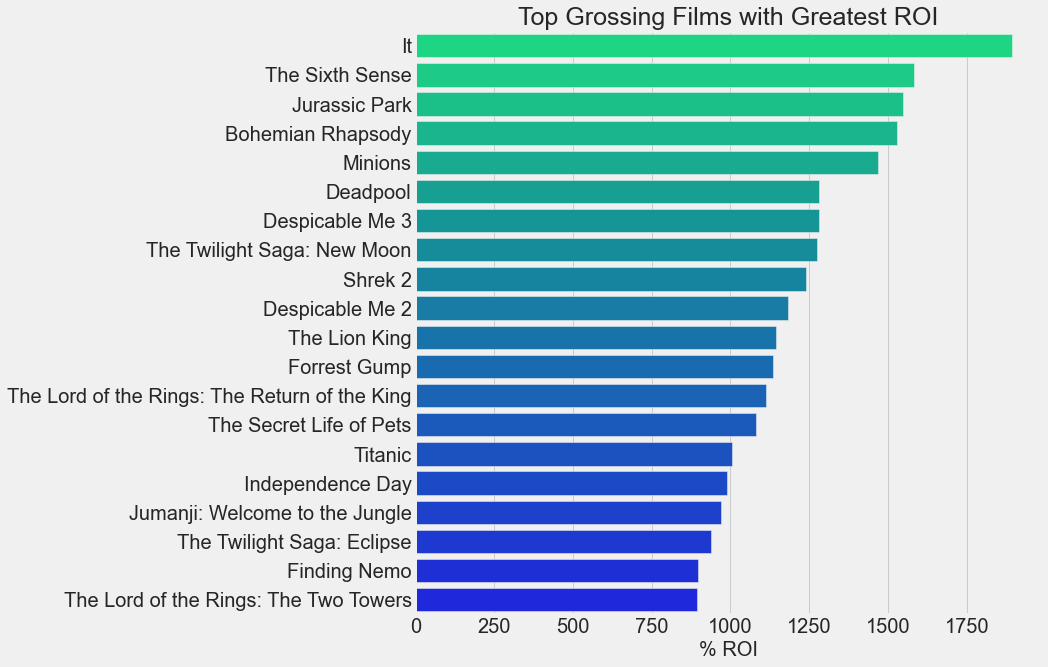

In [227]:
top20_gross_by_roi = top100_gross_films.sort_values\
                    (by='worldwide_roi', ascending=False).head(20)

# plotting top grossing film by ROI
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data=top20_gross_by_roi, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("% ROI", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Grossing Films with Greatest ROI', size = 25)
# plt.savefig('9_top_roi_genres',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

Plotted the top ROI films.

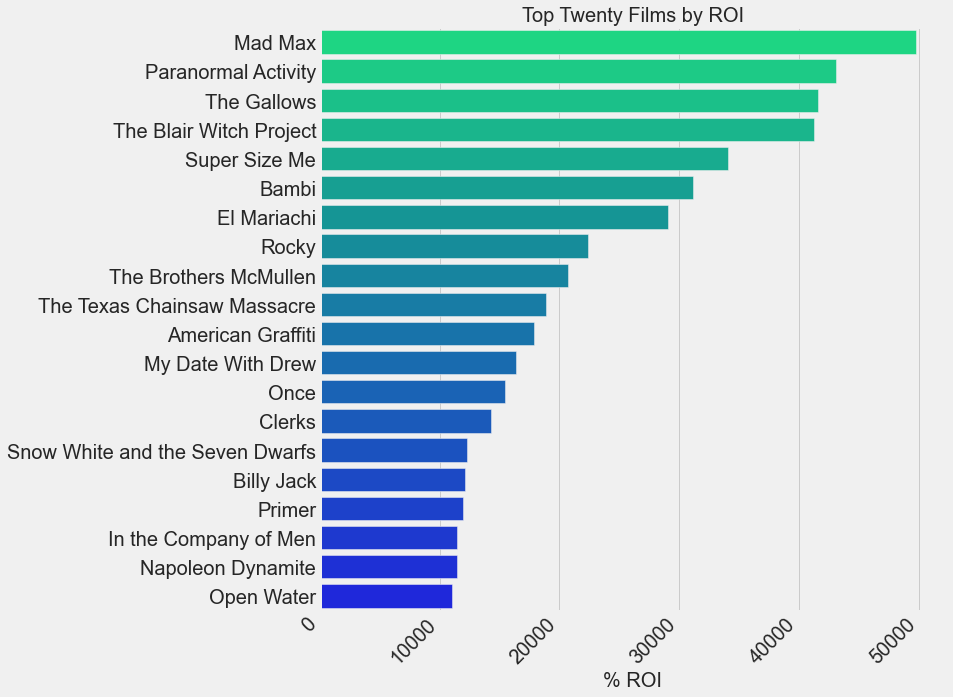

In [228]:
# plotting top 20 films by ROI
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data= top20_roi_films, palette='winter_r')
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set_xlabel("% ROI", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by ROI', size = 20)
# plt.savefig('10_top_20_by_roi',  bbox_inches ="tight",\
#               pad_inches = .25, transparent = False)
plt.show()

# Genre Analysis

Dug deeper into the genre analysis to confirm the results from above. Examined the stats and plotted the distributions of the production budget, worldwide gross, and ROI of each of The Big Five and Hidden Value genres. 

## Top 5 Grossing Genres

In [229]:
action_df = dfr[dfr['genres'].str.contains('action & adventure', case=False)]
unique_titles_a = action_df.drop_duplicates(subset = ['title'])
top100_action = unique_titles_a.sort_values(by='worldwide_gross', ascending=False).head(100)
action = top100_action[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
action.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2011.500000,1.783150e+08,8.985821e+08,7.202671e+08,449.379772
std,5.732241,6.455350e+07,3.525110e+08,3.262740e+08,248.160289
min,1993.000000,5.800000e+07,5.610721e+08,3.559452e+08,118.648403
25%,2008.000000,1.380000e+08,6.550139e+08,5.012625e+08,299.426065
50%,2013.000000,1.725000e+08,8.017142e+08,6.307918e+08,374.943252
75%,2016.000000,2.000000e+08,1.017610e+09,8.292932e+08,523.124676
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,1548.908863


In [230]:
medians_action = [action.production_budget.median(),\
          action.worldwide_gross.median(),\
          action.worldwide_net.median(),\
          action.worldwide_roi.median()]
medians_action

[172500000.0, 801714223.0, 630791787.0, 374.94325196581195]

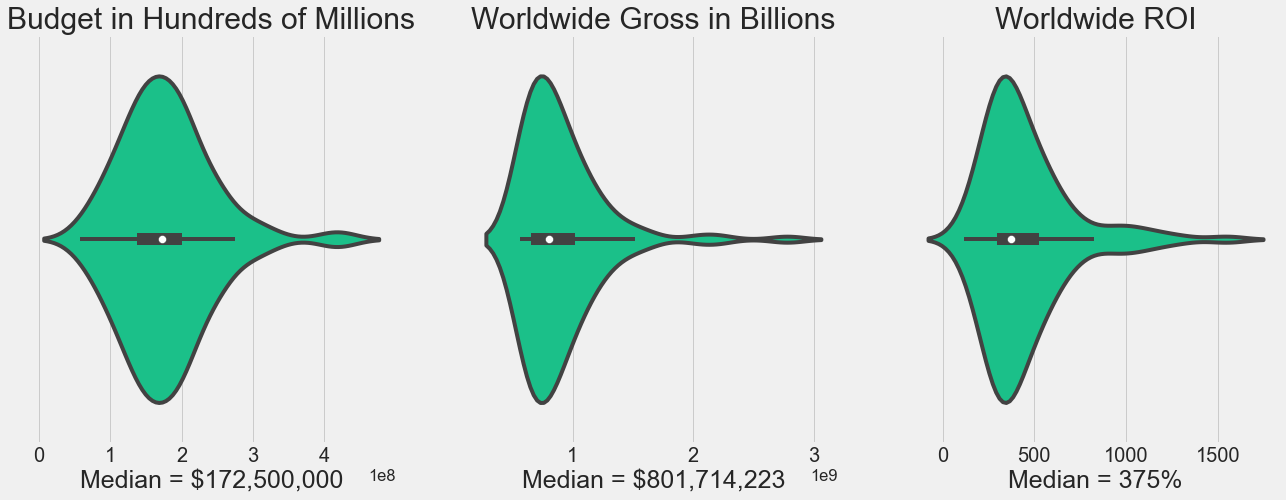

In [231]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=action)
sns.violinplot(ax=ax2, x='worldwide_gross', data=action)
sns.violinplot(ax=ax3, x='worldwide_roi', data=action)
# fig.suptitle('Statistic Distributions For The Top 100 Action & Adventure Films', size=30)
ax1.set_title('Budget in Hundreds of Millions', size = 30)
ax2.set_title('Worldwide Gross in Billions', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $172,500,000', size=25)
ax2.set_xlabel('Median = $801,714,223', size=25)
ax3.set_xlabel('Median = 375%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('11_action_stats',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

In [232]:
scifi_df = dfr[(dfr['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles_s = scifi_df.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles_s.sort_values(by='worldwide_gross', ascending=False).head(100)
scifi = top100_scifi[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
scifi.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2010.510000,1.658720e+08,8.159225e+08,6.500505e+08,475.676275
std,6.694631,6.833449e+07,3.287384e+08,2.985786e+08,345.671420
min,1990.000000,2.200000e+07,4.844686e+08,2.903591e+08,118.648403
25%,2007.000000,1.265000e+08,6.058507e+08,4.533670e+08,278.686918
50%,2013.000000,1.650000e+08,7.569612e+08,5.931777e+08,369.799577
75%,2016.000000,2.000000e+08,9.348282e+08,7.440441e+08,529.197018
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,2252.727273


In [233]:
medians_scifi = [scifi.production_budget.median(),\
          scifi.worldwide_gross.median(),\
          scifi.worldwide_net.median(),\
          scifi.worldwide_roi.median()]
medians_scifi

[165000000.0, 756961210.5, 593177671.5, 369.79957723325975]

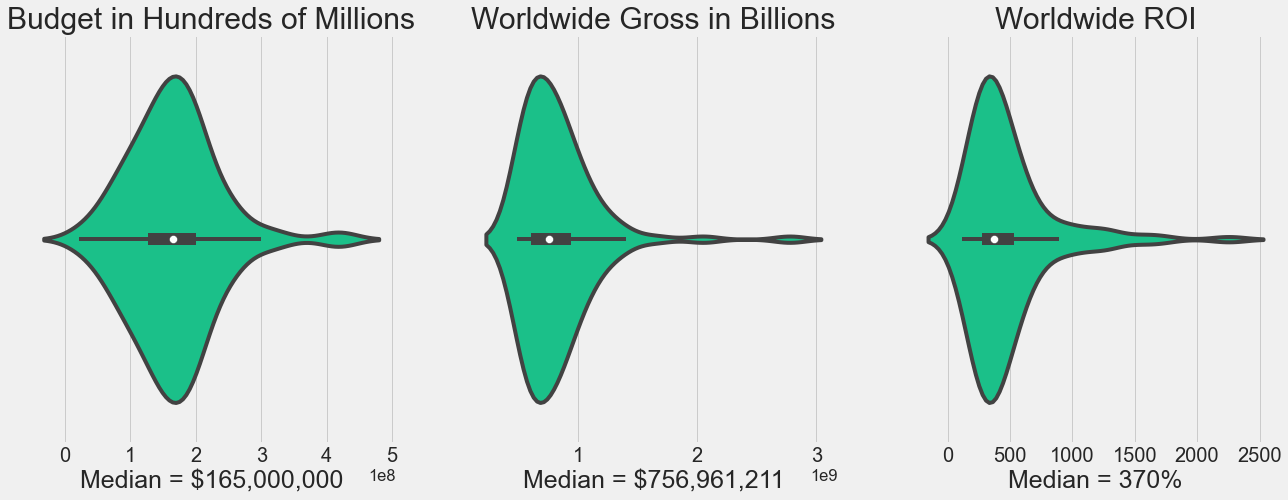

In [234]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=scifi)
sns.violinplot(ax=ax2, x='worldwide_gross', data=scifi)
sns.violinplot(ax=ax3, x='worldwide_roi', data=scifi)
# fig.suptitle('Statistic Distributions For The Top 100 Scifi & Fantasy Films', size=30)
ax1.set_title('Budget in Hundreds of Millions', size = 30)
ax2.set_title('Worldwide Gross in Billions', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $165,000,000', size=25)
ax2.set_xlabel('Median = $756,961,211', size=25)
ax3.set_xlabel('Median = 370%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('12_scifi_stats',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

In [235]:
drama_df = dfr[(dfr['genres'].str.contains('drama', case=False))]
unique_titles_d = drama_df.drop_duplicates(subset = ['title'])
top100_drama = unique_titles_d.sort_values(by='worldwide_gross', ascending=False).head(100)
drama = top100_drama[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
drama.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.00000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2008.40000,1.251080e+08,6.150942e+08,4.899862e+08,623.690578
std,8.96683,6.618245e+07,2.977274e+08,2.808384e+08,654.834085
min,1975.00000,1.200000e+07,3.510404e+08,1.181513e+08,42.964126
25%,2003.75000,7.982500e+07,4.096143e+08,3.129614e+08,232.416201
50%,2011.00000,1.250000e+08,4.906174e+08,3.958058e+08,405.283769
75%,2016.00000,1.662500e+08,7.599021e+08,6.389709e+08,682.499954
max,2018.00000,3.000000e+08,2.208208e+09,2.008208e+09,3822.500000


In [236]:
medians_drama = [drama.production_budget.median(),\
          drama.worldwide_gross.median(),\
          drama.worldwide_net.median(),\
          drama.worldwide_roi.median()]
medians_drama

[125000000.0, 490617448.5, 395805753.0, 405.28376869677413]

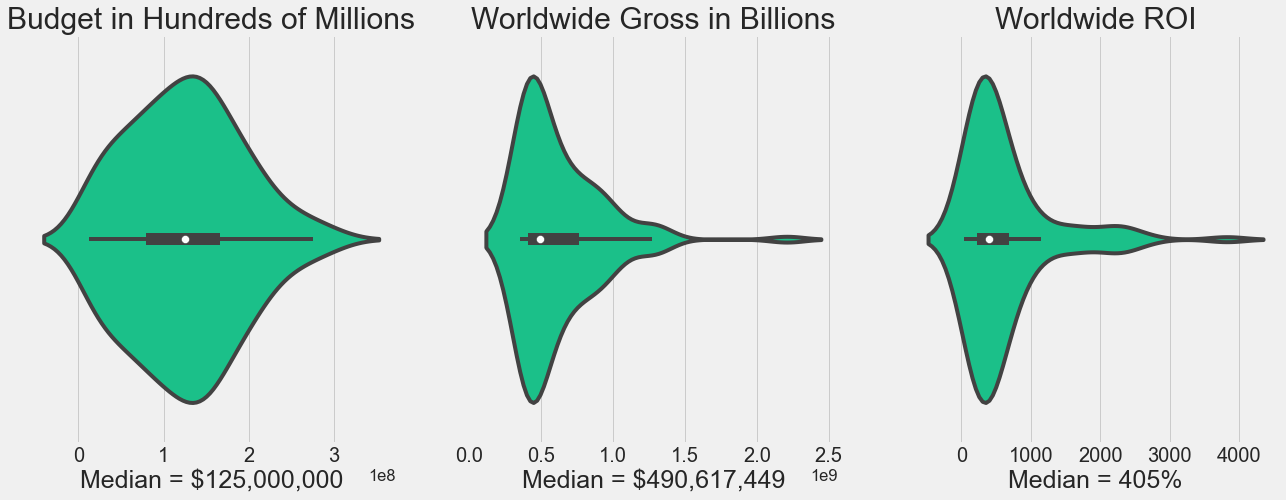

In [237]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=drama)
sns.violinplot(ax=ax2, x='worldwide_gross', data=drama)
sns.violinplot(ax=ax3, x='worldwide_roi', data=drama)
# fig.suptitle('Statistic Distributions For The Top 100 Drama Films', size=30)
ax1.set_title('Budget in Hundreds of Millions', size = 30)
ax2.set_title('Worldwide Gross in Billions', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $125,000,000', size=25)
ax2.set_xlabel('Median = $490,617,449', size=25)
ax3.set_xlabel('Median = 405%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('13_drama_stats',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

In [238]:
family_df = dfr[(dfr['genres'].str.contains('kids & family', case=False))]
unique_titles_f = family_df.drop_duplicates(subset = ['title'])
top100_family = unique_titles_f.sort_values(by='worldwide_gross', ascending=False).head(100)
family = top100_family[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
family.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2008.470000,1.207530e+08,5.769052e+08,4.561522e+08,491.578233
std,7.280047,5.193093e+07,2.521281e+08,2.416251e+08,441.832129
min,1990.000000,1.500000e+07,2.988152e+08,1.413652e+08,78.011220
25%,2004.000000,7.922500e+07,3.629727e+08,2.676657e+08,234.444177
50%,2010.000000,1.262500e+08,5.111185e+08,4.069029e+08,349.360456
75%,2014.250000,1.512500e+08,7.444216e+08,5.651587e+08,559.336854
max,2019.000000,2.600000e+08,1.272470e+09,1.122470e+09,3077.897833


In [239]:
medians_family = [family.production_budget.median(),\
          family.worldwide_gross.median(),\
          family.worldwide_net.median(),\
          family.worldwide_roi.median()]
medians_family

[126250000.0, 511118519.0, 406902906.0, 349.3604560947713]

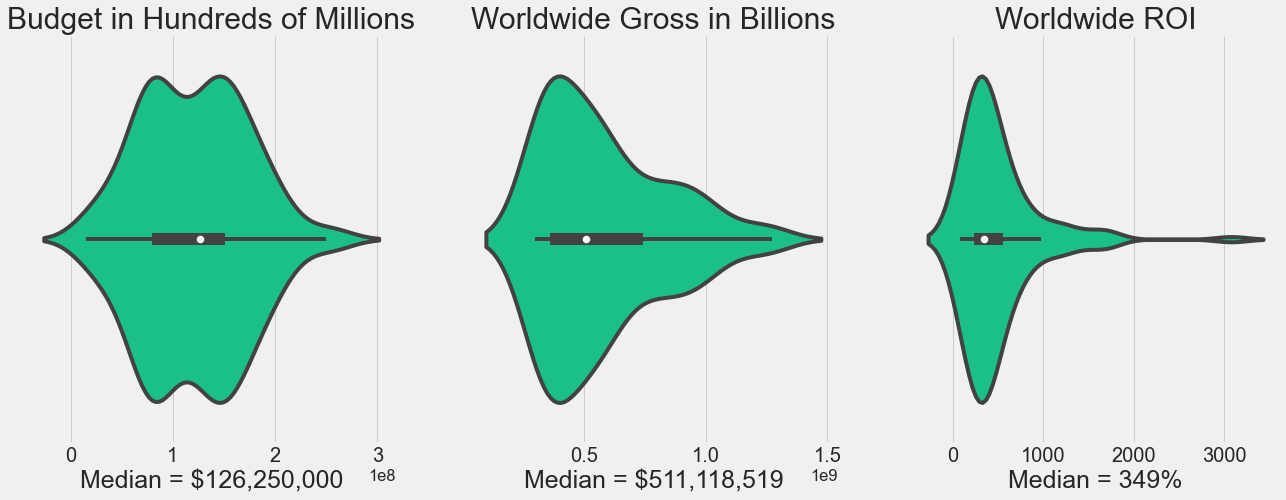

In [240]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=family)
sns.violinplot(ax=ax2, x='worldwide_gross', data=family)
sns.violinplot(ax=ax3, x='worldwide_roi', data=family)
# fig.suptitle('Statistic Distributions For The Top 100 Kids & Family Films', size=30)
ax1.set_title('Budget in Hundreds of Millions', size = 30)
ax2.set_title('Worldwide Gross in Billions', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $126,250,000', size=25)
ax2.set_xlabel('Median = $511,118,519', size=25)
ax3.set_xlabel('Median = 349%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('14_family_stats',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

In [241]:
comedy_df = dfr[(dfr['genres'].str.contains('comedy', case=False))]
unique_titles_c = comedy_df.drop_duplicates(subset = ['title'])
top100_comedy = unique_titles_c.sort_values(by='worldwide_gross', ascending=False).head(100)
comedy = top100_comedy[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net', 'worldwide_roi']]
comedy.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2006.780000,1.002610e+08,5.832438e+08,4.829828e+08,842.968449
std,8.392613,7.039659e+07,3.076128e+08,2.718090e+08,1060.783737
min,1978.000000,5.000000e+06,3.320000e+08,1.462710e+08,78.011220
25%,2002.000000,5.500000e+07,3.846356e+08,3.263143e+08,322.866115
50%,2008.000000,8.500000e+07,5.170838e+08,4.231729e+08,515.828420
75%,2013.000000,1.312500e+08,6.285260e+08,5.279421e+08,925.159407
max,2018.000000,4.250000e+08,2.776345e+09,2.351345e+09,7397.800680


In [242]:
medians_comedy = [comedy.production_budget.median(),\
          comedy.worldwide_gross.median(),\
          comedy.worldwide_net.median(),\
          comedy.worldwide_roi.median()]
medians_comedy

[85000000.0, 517083787.5, 423172876.5, 515.8284198677248]

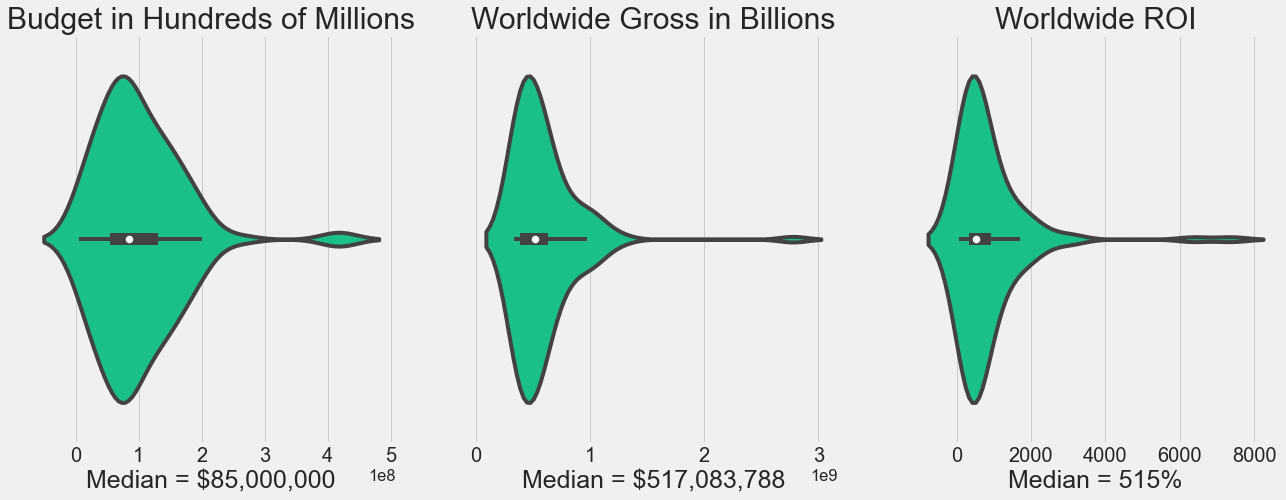

In [243]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=comedy)
sns.violinplot(ax=ax2, x='worldwide_gross', data=comedy)
sns.violinplot(ax=ax3, x='worldwide_roi', data=comedy)
# fig.suptitle('Statistic Distributions For The Top 100 Comedy Films', size=30)
ax1.set_title('Budget in Hundreds of Millions', size = 30)
ax2.set_title('Worldwide Gross in Billions', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $85,000,000', size=25)
ax2.set_xlabel('Median = $517,083,788', size=25)
ax3.set_xlabel('Median = 515%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('18_comedy_stats',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

## Hidden Value Genres

In [244]:
horror_df = dfr[(dfr['genres'].str.contains('horror', case=False))]
unique_titles_h = horror_df.drop_duplicates(subset = ['title'])
top100_horror = unique_titles_h.sort_values(by='adj_ww_gross', ascending=False).head(100)
horror = top100_horror[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net', 'worldwide_roi']]
horror.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2003.830000,5.472600e+07,2.350136e+08,1.802876e+08,1807.417780
std,11.077373,5.477207e+07,1.789311e+08,1.598030e+08,5996.961903
min,1968.000000,4.500000e+05,3.339543e+07,-1.278725e+07,-10.656041
25%,1999.000000,1.500000e+07,1.360322e+08,9.060174e+07,179.703893
50%,2005.000000,4.000000e+07,1.727050e+08,1.316231e+08,389.850233
75%,2012.000000,7.575000e+07,2.760950e+08,2.276776e+08,1249.850474
max,2019.000000,2.750000e+08,1.272470e+09,1.122470e+09,43051.785333


In [245]:
medians_horror = [horror.production_budget.median(),\
          horror.worldwide_gross.median(),\
          horror.worldwide_net.median(),\
          horror.worldwide_roi.median()]
medians_horror

[40000000.0, 172704982.0, 131623056.0, 389.8502330434783]

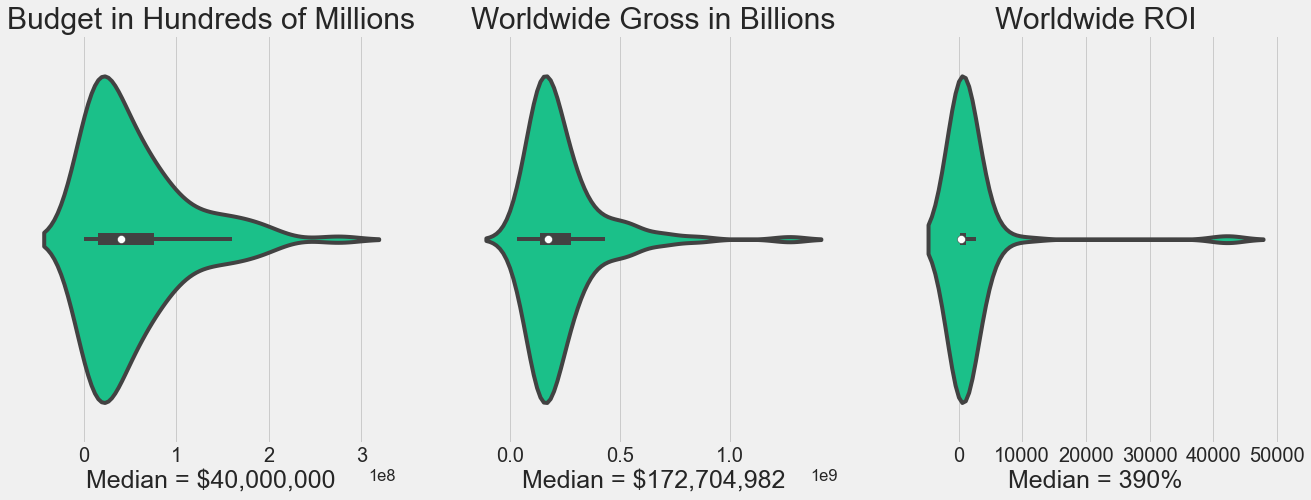

In [246]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=horror)
sns.violinplot(ax=ax2, x='worldwide_gross', data=horror)
sns.violinplot(ax=ax3, x='worldwide_roi', data=horror)
ax1.set_title('Budget in Hundreds of Millions', size = 30)
ax2.set_title('Worldwide Gross in Billions', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $40,000,000', size=25)
ax2.set_xlabel('Median = $172,704,982', size=25)
ax3.set_xlabel('Median = 390%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('17_horror_stats',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

In [247]:
mystery_df = dfr[(dfr['genres'].str.contains('mystery & suspense', case=False))]
unique_titles_m = mystery_df.drop_duplicates(subset = ['title'])
top100_mystery = unique_titles_m.sort_values(by='worldwide_gross', ascending=False).head(100)
mystery = top100_mystery[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]
mystery.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2005.120000,1.009113e+08,4.982518e+08,3.973405e+08,687.026202
std,9.177575,6.754731e+07,3.549953e+08,3.124608e+08,903.767450
min,1975.000000,5.000000e+06,2.398140e+08,8.924622e+07,50.997840
25%,1999.000000,5.937500e+07,3.015452e+08,2.304944e+08,242.336559
50%,2007.000000,9.000000e+07,3.656959e+08,2.996501e+08,344.487165
75%,2012.000000,1.300000e+08,5.550299e+08,4.300212e+08,700.470452
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,5479.296120


In [248]:
medians_mystery = [mystery.production_budget.median(),\
          mystery.worldwide_gross.median(),\
          mystery.worldwide_net.median(),\
          mystery.worldwide_roi.median()]
medians_mystery

[90000000.0, 365695896.0, 299650070.5, 344.48716520408163]

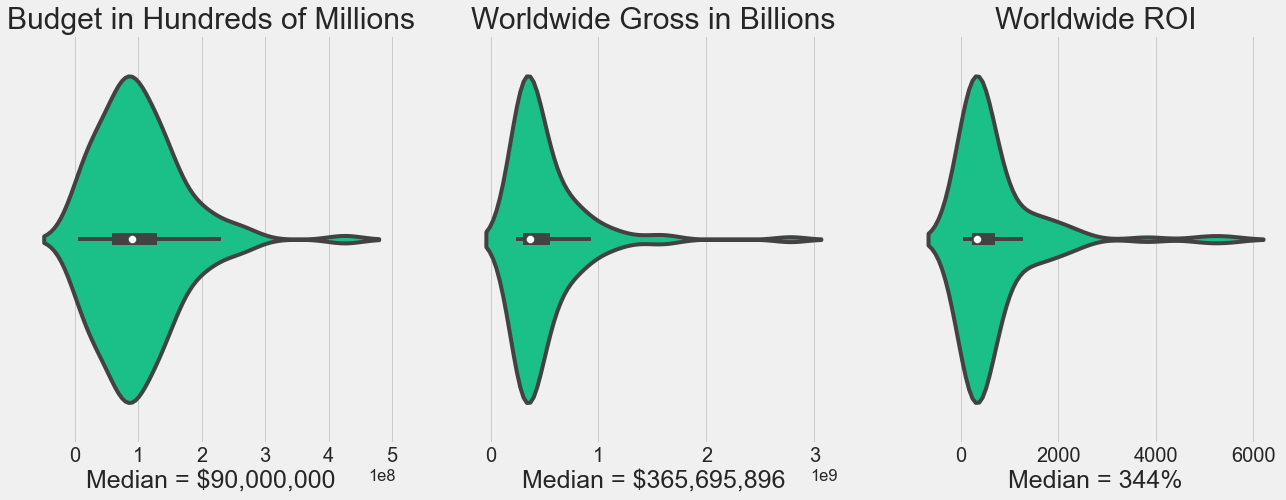

In [249]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
sns.violinplot(ax=ax1, x='production_budget', data=mystery)
sns.violinplot(ax=ax2, x='worldwide_gross', data=mystery)
sns.violinplot(ax=ax3, x='worldwide_roi', data=mystery)
ax1.set_title('Budget in Hundreds of Millions', size = 30)
ax2.set_title('Worldwide Gross in Billions', size = 30)
ax3.set_title('Worldwide ROI', size = 30)
ax1.set_xlabel('Median = $90,000,000', size=25)
ax2.set_xlabel('Median = $365,695,896', size=25)
ax3.set_xlabel('Median = 344%', size=25)
ax1.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax3.tick_params(axis="x", labelsize=20)
# plt.savefig('23_mystery_stats',  bbox_inches ="tight",\
#             pad_inches = .25, transparent = False)
plt.show()

# Estimated Inital Cost

Calculated the cost for producing and marketing the first slate of films based on data from [The Numbers](https://www.the-numbers.com/). The top six studios release, on average, fifteen films per year. The median production cost of top grossing film is 172,500,000 USD, and a rough estimate of the marketing budget for a film is half of the production budget. Running a calculation on those figures gave an intial cost estimate of **3,881,250,000 USD** for the first year's films.

In [250]:
avg_films_per_year = 15 # big six distributors 
est_inital_prod_costs = avg_films_per_year*top100_gross_films.production_budget.median()
est_marketing_costs = est_inital_prod_costs/2 # rough estimate based on past trends
total_start_costs = est_inital_prod_costs + est_marketing_costs
total_start_costs

3881250000.0

# Conclusions
* Total estimated initial cost for the production and marketing of the first fifteen films: 3,881,250,000 USD.
* The bulk of revenue will come from the international market.
* Action & Adventure, SciFi & Fantasy, Drama, Kids & Family, and Animation are the best bets for maximum gross profits.
* Comedy, Horror, Mystery, and Drama offer the best possibilities for value and ROI.

# Next Steps 

* Look into the prospect of buying a production company rather than starting from scratch.
* Research renting vs building physical production facilities.
* Incorporate the streaming market into the analysis.

# Optional Analysis of Creative Talent

Due to time constraints, the following analysis was not incorporated into the presentation; However, it may provide valuable insights regarding film project personnel moving forward.

# Top Creative Talent

In [251]:
# dropping problematic titles with multiple entries

problem_titles = ['Titanic', 'Cinderella', 'Snow White and the Seven Dwarfs',\
                  'Beauty and the Beast', 'Bambi', 'Avatar', 'Pinocchio', 'Ben-Hur']
dfi = dfi[~dfi.title.isin(problem_titles)]

In [252]:
# getting column names
dfi.columns

Index(['nconst', 'primary_name', 'tconst', 'category', 'genres', 'date',
       'title', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'adj_prod_budg',
       'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross', 'adj_dom_net',
       'adj_ww_net', 'adj_i_net', 'dom_roi', 'ww_roi', 'i_roi'],
      dtype='object')

# Top 20 Actors By Worldwide Gross

In [253]:
# creating actor dataframe
actor_df = dfi[dfi['category'].str.contains('actor')]

# creating preliminary top 100 actors list
top100_grossing_actors = actor_df.groupby(['primary_name'])\
                                          .worldwide_gross.sum()\
                                          .sort_values(ascending=False).head(100) 
top100_actors = pd.DataFrame(top100_grossing_actors)

# resetting index
reset_idx = top100_actors.reset_index()

# getting name list
actor_list = list(reset_idx.primary_name)

# running imdb actor list against rt movie list to work-around problematic titles.
gross = []
for name in actor_list:
    value = dfr[dfr['actors'].str.contains(name)].worldwide_gross.sum()
    gross.append(value)
    
#  creating new gross dataframe
dict = {'primary_name': actor_list, 'worldwide_gross': gross}
gross_df = pd.DataFrame(dict, index=actor_list)
top50_gross_actors = gross_df.sort_values(by='worldwide_gross', ascending=False).head(50)

# getting movie count
movie_count_m = actor_df.groupby(['primary_name']).title.count()
count_m = pd.DataFrame(movie_count_m)

# joining dfs
joined_m = top50_gross_actors.join(count_m)

# adding mean gross column
joined_m['mean_gross'] = joined_m.worldwide_gross/joined_m.title
joined_m = joined_m.reset_index()
joined_m = joined_m.rename(columns={'primary_name': 'Actor',\
                                       'title': 'Number of Titles',\
                                    'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

# sorting top 20 cumulative gross and mean gross films
top20_cuml_gross_actors =  joined_m.sort_values(by='Cumulative Gross',\
                                                ascending=False).head(20)
top20_mean_gross_actors = joined_m.sort_values(by='Mean Gross per Title',\
                                               ascending=False).head(20)

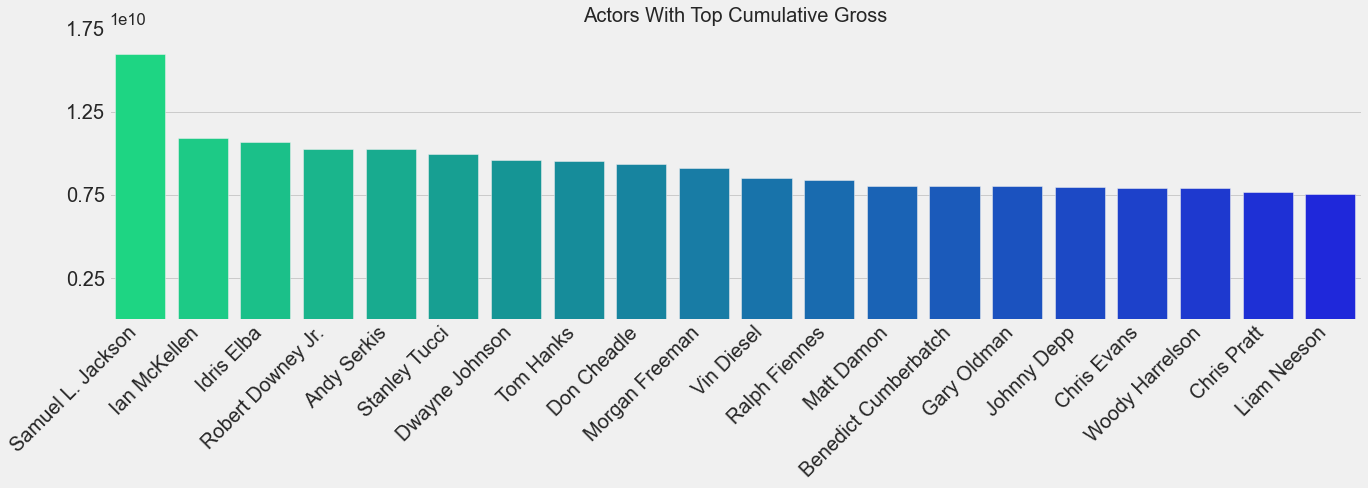

In [254]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='Actor', y='Cumulative Gross', data=top20_cuml_gross_actors, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .75*10**10, 1.25*10**10, 1.75*10**10])
plt.xticks(rotation=45, ha='right')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Actors With Top Cumulative Gross", fontsize=20)
# plt.savefig('22_actor_gross',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

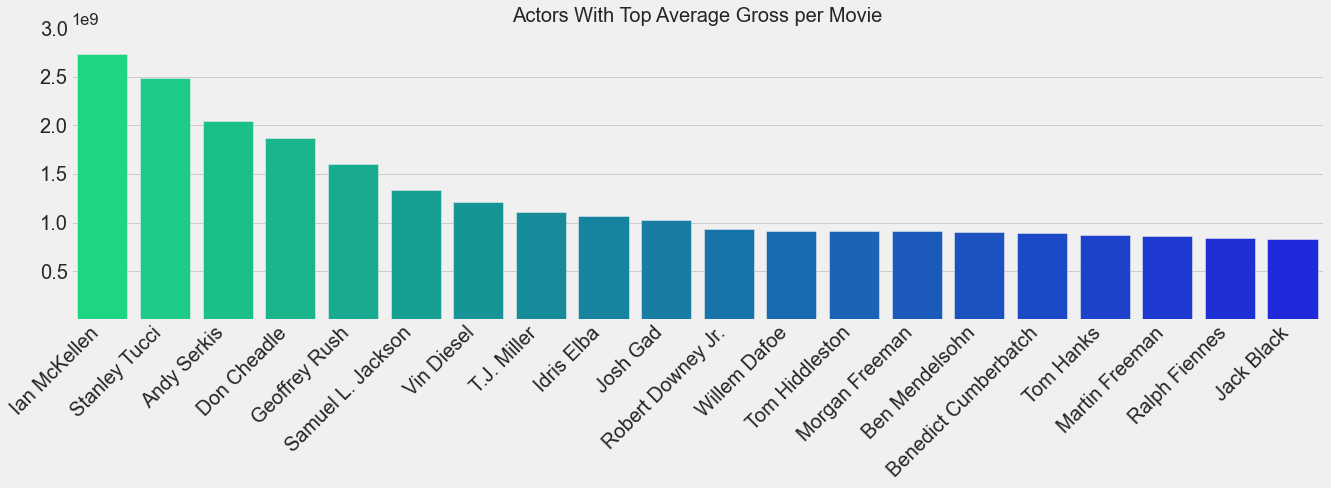

In [255]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross_actors,\
            palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9,\
                                  2.0*10**9, 2.5*10**9, 3.0*10**9])
ax.set_xlabel("") 
ax.set_ylabel("")
ax.set_title("Actors With Top Average Gross per Movie", fontsize=20) 
# plt.savefig('21_actor_mean',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show() 

## Actors Top Genres

In [256]:
# finding optimal genre by imdb cumulative gross for each actor in top 100
optimal_genre = []
for actor in actor_list:
    collection = []
    for genre in genres_i:
        gross = actor_df[(actor_df['primary_name'] == actor)\
                         & (actor_df.genres.str.contains(genre, case=False))]\
                        .worldwide_gross.sum()
        collection.append((actor, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

# creating actor optimal genre dataframe
actor_genre = []
actor_gross = []
for i in range(100):
    actor_genre.append(optimal_genre[i][1])
    actor_gross.append(optimal_genre[i][2])
actor_genre_df = pd.DataFrame()
actor_genre_df['Actor'] = actor_list
actor_genre_df['Genre'] = actor_genre
actor_genre_df['worldwide_gross'] = actor_gross

In [257]:
# optimal genre by worldwide gross for each actor
ag = actor_genre_df.sort_values(by='worldwide_gross', ascending=False).head(20)
ag[['Actor', 'Genre']].head()

,Actor,Genre
0,Robert Downey Jr.,Adventure
2,Chris Evans,Action
1,Dwayne Johnson,Action
3,Chris Hemsworth,Action
7,Vin Diesel,Action


In [258]:
# genre counts for top 50
actor_genre_df.sort_values(by='worldwide_gross',\
                           ascending=False).head(50).Genre.value_counts()

Action       25
Adventure    18
Comedy        6
Sci-Fi        1
Name: Genre, dtype: int64

# Top 20 Actresses By Worldwide Gross

Created an initial data frame by filtering by category. Formed a new data frame by grouping by name, sorting by worldwide gross, and collecting the top one hundred names. Next, a name list was created by resetting the new data frame index and wrapping it in `list()`. Kate Winslet was missing from actress category and was added to the name list by hand.  This list was run against the Rotten Tomatoes movie list as a work-around of the problematic titles dropped in the IMDb movie list, and a new gross profit data frame was created with a complete list of movies. The movie count for each individual was calculated and a data frame was created from the result. These two new data frames were joined  and a mean gross column was added. Values for Kate Winslet were calculated and appended to the data frame. The top twenty grossing and top twenty mean grossing individuals were plotted.

In [259]:
# creating actress df
actress_df = dfi[dfi['category'].str.contains('actress')]

# initial top 100
top100_grossing_actresses = actress_df.groupby(['primary_name'])\
                                               .worldwide_gross.sum()\
                                               .sort_values(ascending=False).head(100) 
top100_actresses = pd.DataFrame(top100_grossing_actresses)

# resetting index
reset_idx_f = top100_actresses.reset_index()

# getting name list and adding kate winslet
actress_list = list(reset_idx_f.primary_name)[:99]
actress_list.append('Kate Winslet')

# running imdb actress list against rt movie list to work-around problematic titles.
gross_f = []
for name in actress_list:
    value = dfr[dfr['actors'].str.contains(name)].worldwide_gross.sum()
    gross_f.append(value)

#  creating new adj gross dataframe
dict = {'primary_name': actress_list, 'worldwide_gross': gross_f}
gross_df_f = pd.DataFrame(dict, index=actress_list)
top50_gross_actresses = gross_df_f.sort_values(by='worldwide_gross', ascending=False).head(50)

# movie count
movie_count_f = actress_df.groupby(['primary_name']).title.count()
count_f = pd.DataFrame(movie_count_f)

# joining dfs
joined_f = top50_gross_actresses.join(count_f)

# added mean gross column
joined_f['mean_gross'] = joined_f.worldwide_gross/joined_f.title
joined_f = joined_f.reset_index()
joined_f = joined_f.rename(columns={'primary_name': 'Actress',\
                                       'title': 'Number of Titles',\
                                    'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

# sorting top 20s
top20_cuml_gross_actresses = joined_f.sort_values\
                            (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actresses = joined_f.sort_values\
                            (by='Mean Gross per Title', ascending=False).head(20)

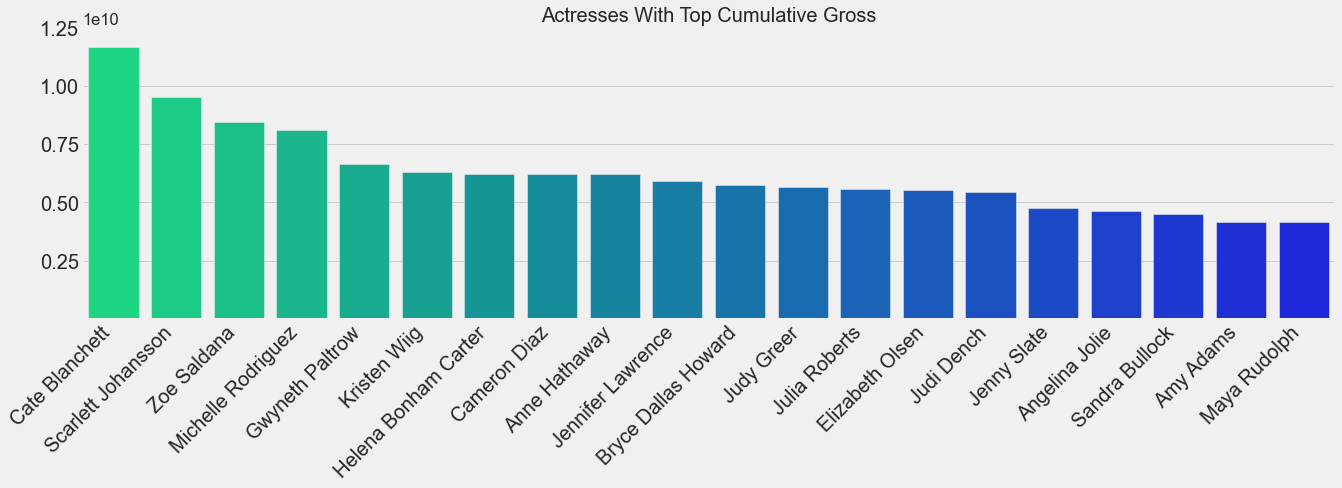

In [260]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='Actress', y='Cumulative Gross',\
            data=top20_cuml_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .5*10**10, .75*10**10,\
                                  1.0*10**10, 1.25*10**10])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Actresses With Top Cumulative Gross", fontsize=20)
# plt.savefig('19_actress_gross',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show()

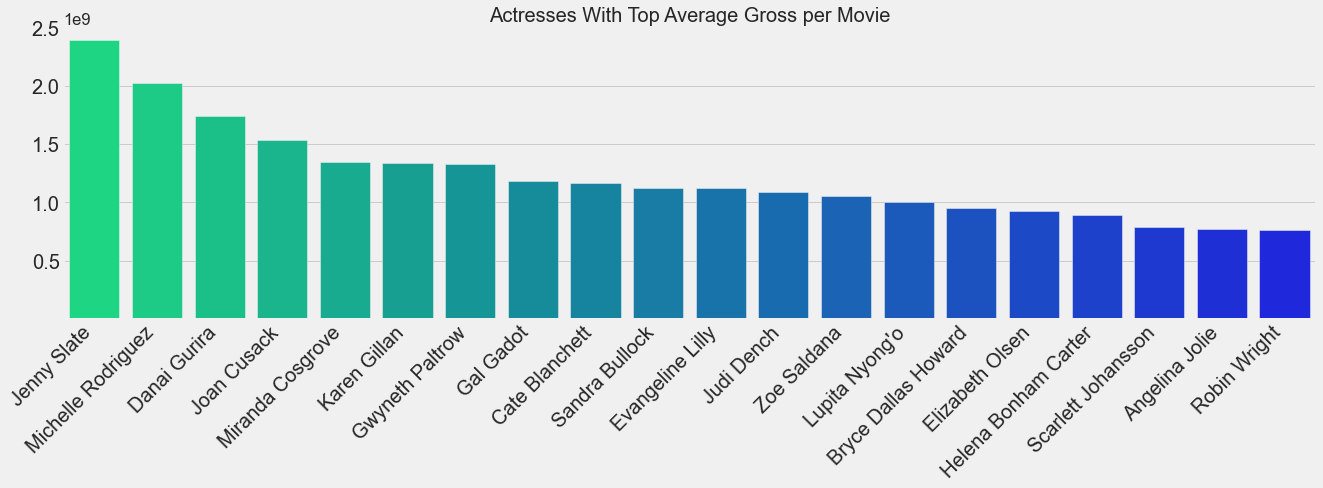

In [261]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='Actress', y='Mean Gross per Title',\
            data=top20_mean_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9])
ax.set_xlabel("") 
ax.set_ylabel("")
ax.set_title("Actresses With Top Average Gross per Movie", fontsize=20) 
# plt.savefig('20_actress_mean',  bbox_inches ="tight", pad_inches = .25, transparent = False)
plt.show() 

## Actress Top Genres

In [262]:
# finding optimal genre by adjusted gross
optimal_genre = []
for actress in actress_list:
    collection = []
    for genre in genres_i:
        gross = actress_df[(actress_df['primary_name'] == actress)\
                         & (actress_df.genres.str.contains(genre, case=False))]\
                         .worldwide_gross.sum()
        collection.append((actress, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

# creating optimal genre dataframe
actress_genre = []
actress_gross = []
for i in range(100):
    actress_genre.append(optimal_genre[i][1])
    actress_gross.append(optimal_genre[i][2])
actress_genre_df = pd.DataFrame()
actress_genre_df['Actress'] = actress_list
actress_genre_df['Genre'] = actress_genre
actress_genre_df['worldwide_gross'] = actress_gross

In [263]:
# optimal genre for each actress
atsg = actress_genre_df.sort_values(by='worldwide_gross', ascending=False)
atsg[['Actress', 'Genre']].head()

,Actress,Genre
0,Jennifer Lawrence,Sci-Fi
1,Scarlett Johansson,Sci-Fi
4,Cate Blanchett,Adventure
3,Kristen Wiig,Comedy
5,Bryce Dallas Howard,Sci-Fi


In [264]:
# genre counts for top 50
actress_genre_df.sort_values(by='worldwide_gross',\
                             ascending=False).head(50).Genre.value_counts()

Action       16
Comedy       10
Adventure     8
Sci-Fi        6
Fantasy       5
Drama         5
Name: Genre, dtype: int64

## Top Directors by Worldwide Gross

Created an initial data frame by filtering by category. Formed a new data frame by grouping by name, sorting by worldwide gross, and collecting the top one hundred names. Next, a name list was created by resetting the new data frame index and wrapping it in `list()`. James Cameron was missing from director category and was added to the name list by hand.  This list was run against the Rotten Tomatoes movie list as a work-around of the problematic titles dropped in the IMDb movie list, and a new gross profit data frame was created with a complete list of movies. The movie count for each individual was calculated and a data frame was created from the result. These two new data frames were joined  and a mean gross column was added. Values for James Cameron were calculated and appended to the data frame. The top twenty grossing and top twenty mean grossing individuals were plotted.

In [265]:
# creating director df
director_df = dfi[dfi['category'].str.contains('director')]

# top 100 directors
top100_adj_gross_directors = director_df.groupby(['primary_name'])\
                                                 .worldwide_gross.sum()\
                                                 .sort_values(ascending=False).head(100)
top100_directors = pd.DataFrame(top100_adj_gross_directors)

In [266]:
# resting index
reset_idx_d = top100_directors.reset_index()

# getting name list and adding james cameron
director_list = list(reset_idx_d.primary_name)[:99] 
director_list.append('James Cameron')

In [267]:
# running imdb director list against rt movie list to work-around problematic titles.
gross_d = []
for name in director_list:
    value = dfr[dfr['directors'].str.contains(name)].adj_ww_gross.sum()
    gross_d.append(value)

#  creating new adj gross dataframe
dict = {'primary_name': director_list, 'adj_ww_gross': gross_d}
gross_df_d = pd.DataFrame(dict, index=director_list)
top50_adj_gross_directors = gross_df_d.sort_values\
                            (by='adj_ww_gross', ascending=False).head(50)

In [268]:
# movie count
movie_count_d = director_df.groupby(['primary_name']).title.count()
count_d = pd.DataFrame(movie_count_d)

# joining dfs
joined_d = top50_adj_gross_directors.join(count_d)

# adding mean gross column
joined_d['mean_gross'] = joined_d.adj_ww_gross/joined_d.title
joined_d = joined_d.reset_index()
joined_d = joined_d.rename(columns={'primary_name': 'Director',\
                                       'title': 'Number of Titles',\
                                    'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [269]:
# adding values for james cameron
joined_d.loc[[2],'Number of Titles'] = dfr[dfr.directors.str.contains\
                                           ('James Cameron')].title.count()
joined_d.loc[[2], 'Mean Gross per Title'] = joined_d.loc\
                                            [[2], 'Cumulative Gross']\
                                            /joined_d.loc[[2],'Number of Titles']

In [270]:
# creating top 20 lists
top20_cuml_gross_directors = joined_d.sort_values\
                             (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_directors = joined_d.sort_values\
                             (by='Mean Gross per Title', ascending=False).head(20)

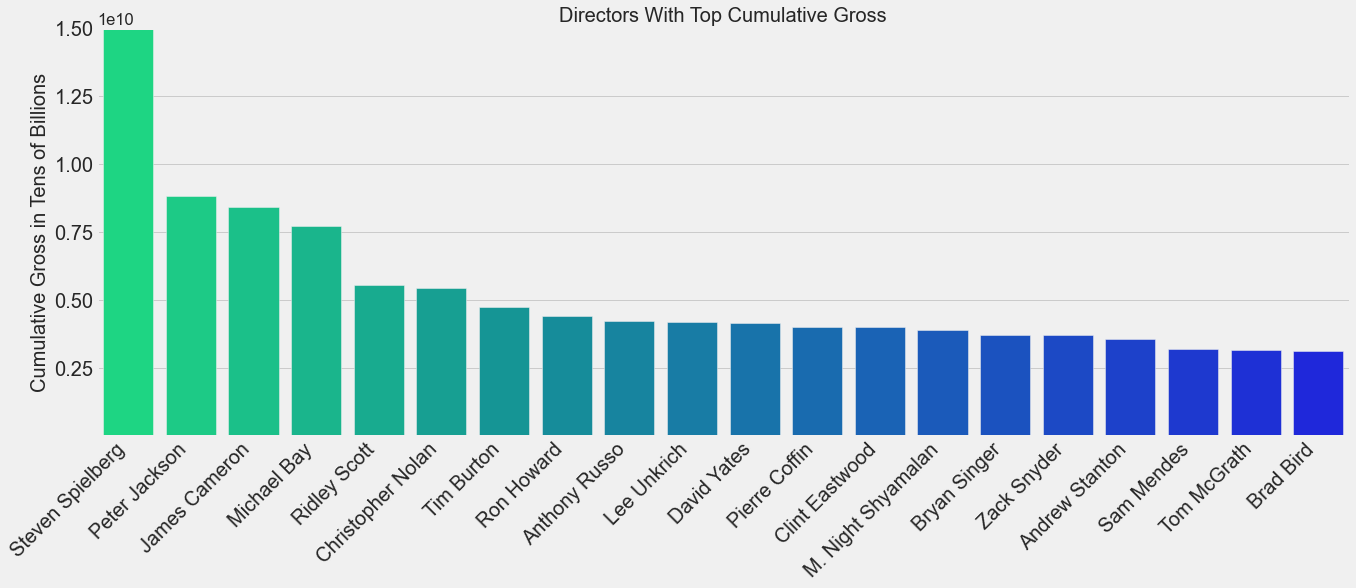

In [271]:
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x='Director', y='Cumulative Gross',\
            data=top20_cuml_gross_directors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .5*10**10, .75*10**10,\
                                  1.0*10**10, 1.25*10**10, 1.5*10**10])
ax.set_xlabel("")
ax.set_ylabel("Cumulative Gross in Tens of Billions" , fontsize=20 )
ax.set_title("Directors With Top Cumulative Gross", fontsize=20)
plt.show()

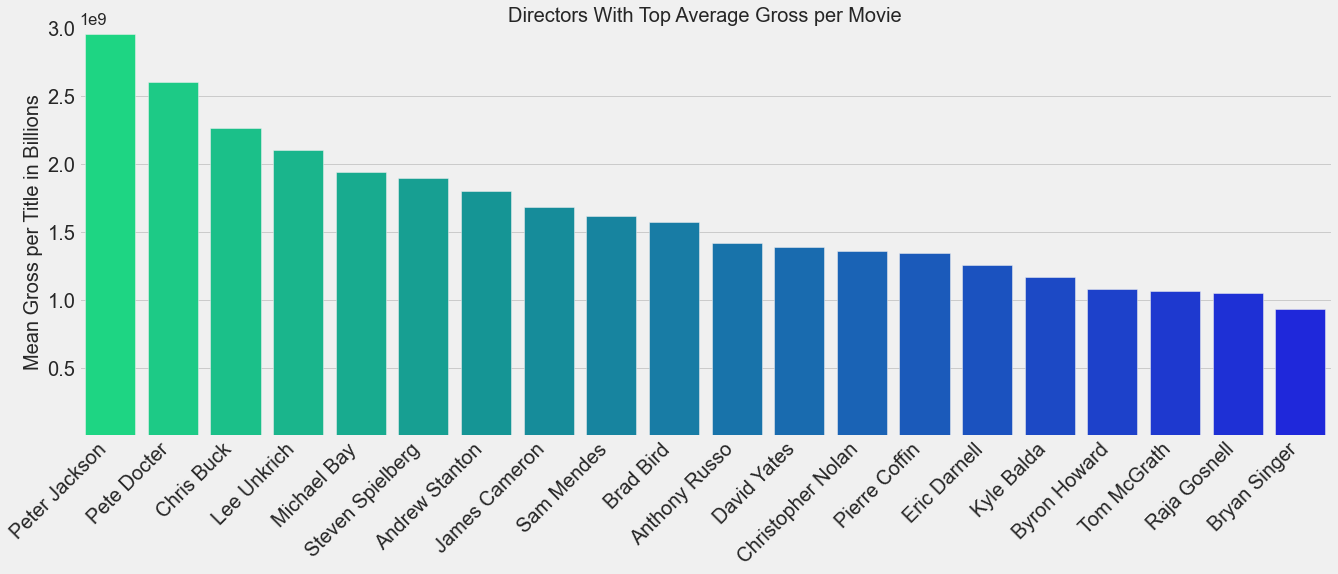

In [272]:
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x='Director', y='Mean Gross per Title',\
            data=top20_mean_gross_directors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9,\
                                  1.5*10**9, 2.0*10**9, 2.5*10**9, 3.0*10**9])
ax.set_xlabel("") 
ax.set_ylabel("Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Directors With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Director Top Genres

In [273]:
# finding optimal genre by adjusted gross
optimal_genre = []
for director in director_list:
    collection = []
    for genre in genres_i:
        gross = director_df[(director_df['primary_name'] == director)\
                         & (director_df.genres.str.contains(genre, case=False))]\
                        .worldwide_gross.sum()
        collection.append((director, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

# creating optimal genre dataframe
director_genre = []
director_gross = []
for i in range(100):
    director_genre.append(optimal_genre[i][1])
    director_gross.append(optimal_genre[i][2])
director_genre_df = pd.DataFrame()
director_genre_df['director'] = director_list
director_genre_df['genre'] = director_genre
director_genre_df['worldwide_gross'] = director_gross

In [274]:
# optimal genres for each
director_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

,director,genre,worldwide_gross
0,Anthony Russo,Sci-Fi,3.902606e+09


In [275]:
# genre counts for top 100
director_genre_df.genre.value_counts()

Action         29
Comedy         27
Sci-Fi         11
Adventure      10
Fantasy         5
Drama           5
Documentary     4
Thriller        2
Animation       2
Musical         2
Horror          1
Family          1
NaN             1
Name: genre, dtype: int64

In [276]:
# genre counts for top 50
director_genre_df.sort_values(by='worldwide_gross',\
                              ascending=False).head(50).genre.value_counts()

Action       14
Comedy       14
Adventure     8
Sci-Fi        8
Fantasy       4
Drama         2
Name: genre, dtype: int64

# Top Writers by Gross

Created an initial data frame by filtering by category. Formed a new data frame by grouping by name, sorting by worldwide gross, and collecting the top one hundred names. Next, a name list was created by resetting the new data frame index and wrapping it in `list()`. This list was run against the Rotten Tomatoes movie list as a work-around of the problematic titles dropped in the IMDb movie list, and a new gross profit data frame was created with a complete list of movies. The movie count for each individual was calculated, and a data frame was created from the result. These two new data frames were joined and a mean gross column was added. The top twenty grossing and top twenty mean grossing individuals were plotted.

In [277]:
# creating writer df
writer_df = dfi[dfi['category'].str.contains('writer')]

# initial top 100
top100_gross_writers = writer_df.groupby(['primary_name'])\
                                         .worldwide_gross.sum()\
                                         .sort_values(ascending=False).head(100) 
top100_writers = pd.DataFrame(top100_gross_writers)

# resetting index
reset_idx_w = top100_writers.reset_index()

# getting name list
writer_list = list(reset_idx_w.primary_name)

# running imdb writer list against rt movie list to work-around problematic titles.
gross_w = []
for name in writer_list:
    value = dfr[dfr['authors'].str.contains(name)].worldwide_gross.sum()
    gross_w.append(value)

#  creating new adj gross dataframe
dict = {'primary_name': writer_list, 'worldwide_gross': gross_w}
gross_df_w = pd.DataFrame(dict, index=writer_list)
top50_gross_writers = gross_df_w.sort_values(by='worldwide_gross',\
                                             ascending=False).head(50)

# movie count
movie_count_w = writer_df.groupby(['primary_name']).title.count()
count_w = pd.DataFrame(movie_count_w)

# joining dfs
joined_w = top50_gross_writers.join(count_w)

# added mean gross column
joined_w['mean_gross'] = joined_w.worldwide_gross/joined_w.title
joined_w = joined_w.reset_index()
joined_w = joined_w.rename(columns={'primary_name': 'Writer',\
                                       'title': 'Number of Titles',\
                                    'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

# sorting top 20s
top20_cuml_gross_writers = joined_w.sort_values\
                        (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_writers = joined_w.sort_values\
                           (by='Mean Gross per Title', ascending=False).head(20)

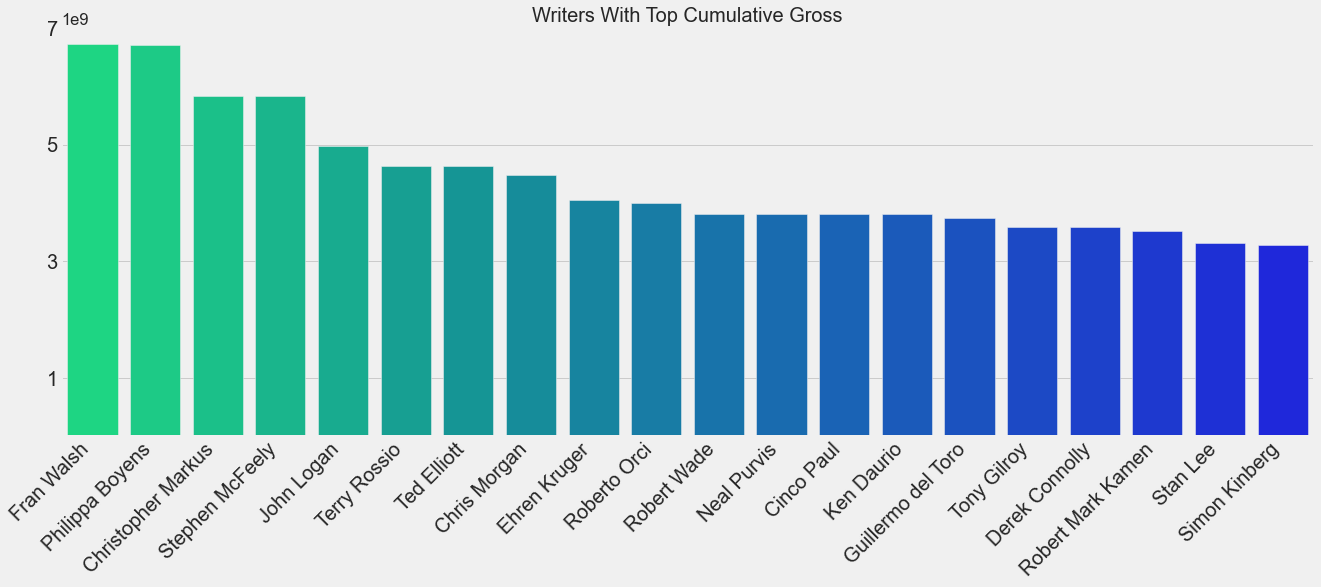

In [278]:
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x='Writer', y='Cumulative Gross',\
            data=top20_cuml_gross_writers, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[1*10**9, 3*10**9, 5*10**9, 7*10**9])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Writers With Top Cumulative Gross", fontsize=20)
plt.show()

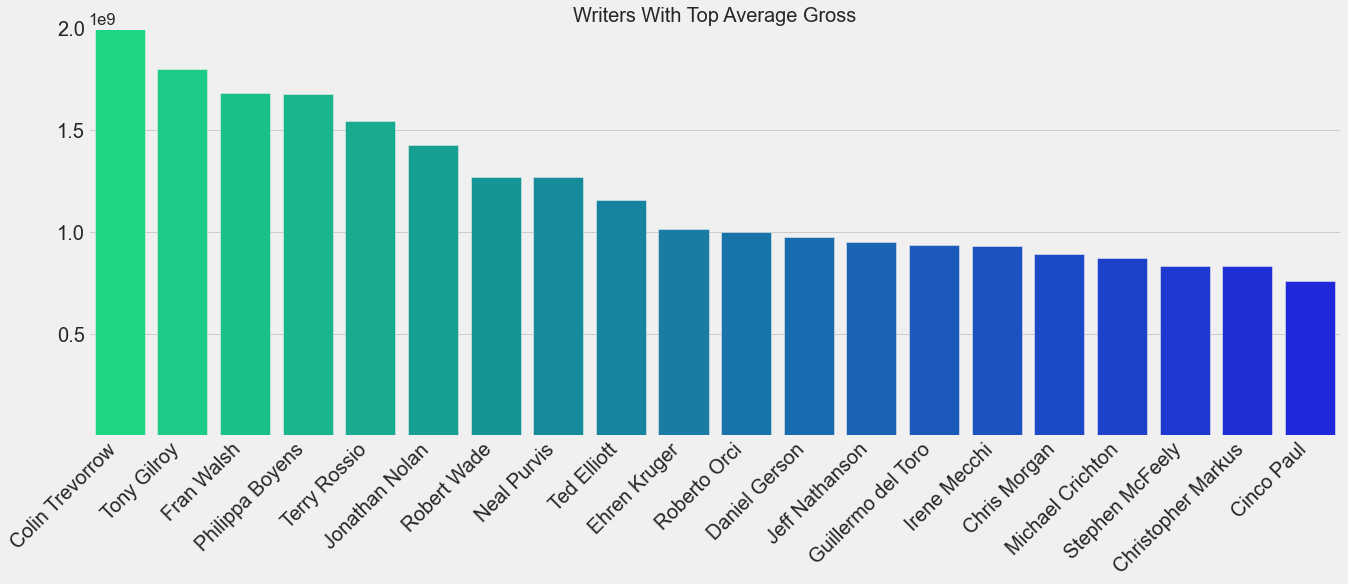

In [279]:
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x='Writer', y='Mean Gross per Title',\
            data=top20_mean_gross_writers, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1*10**9, 1.5*10**9, 2*10**9])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Writers With Top Average Gross", fontsize=20)
plt.show()

## Writer Top Genres

In [280]:
# finding optimal genre by adjusted gross 
optimal_genre = []
for writer in writer_list:
    collection = []
    for genre in genres_i:
        gross = writer_df[(writer_df['primary_name'] == writer)\
                         & (writer_df.genres.str.contains(genre, case=False))]\
                         .worldwide_gross.sum()
        collection.append((writer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

# creating optimal genre dataframe
writer_genre = []
writer_gross = []
for i in range(100):
    writer_genre.append(optimal_genre[i][1])
    writer_gross.append(optimal_genre[i][2])
writer_genre_df = pd.DataFrame()
writer_genre_df['writer'] = writer_list
writer_genre_df['genre'] = writer_genre
writer_genre_df['worldwide_gross'] = writer_gross

#optimal genres for each
writer_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

# genre counts for top 100
writer_genre_df.genre.value_counts()

# genre counts for top 50
writer_genre_df.sort_values(by='worldwide_gross',\
                            ascending=False).head(50).genre.value_counts()

Action       25
Adventure    14
Sci-Fi        5
Fantasy       4
Comedy        2
Name: genre, dtype: int64

# Top Producers by Gross

Created an initial data frame by filtering by category. Formed a new data frame by grouping by name, sorting by worldwide gross, and collecting the top one hundred names. Next, a name list was created by resetting the new data frame index and wrapping it in `list()`. This list was run against the Rotten Tomatoes movie list as a work-around of the problematic titles dropped in the IMDb movie list, and a new gross profit data frame was created with a complete list of movies. The movie count for each individual was calculated, and a data frame was created from the result. These two new data frames were joined and a mean gross column was added. The top twenty grossing and top twenty mean grossing individuals were plotted.

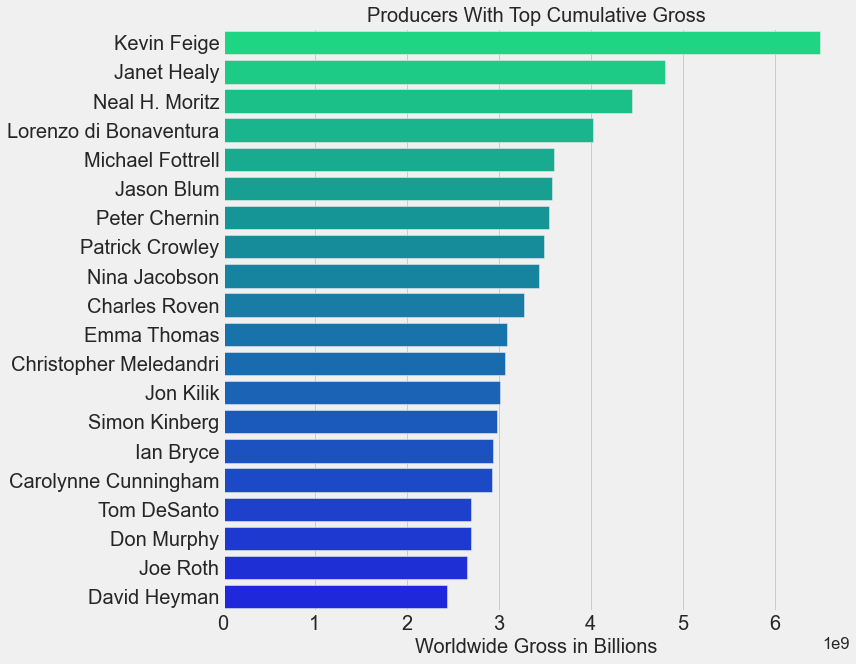

In [281]:
# creating imdb dataframes
title_dfi_p = dfi[['title', 'primary_name', 'worldwide_gross',\
                   'adj_ww_gross', 'date', 'category', 'genres']]
producer_df = title_dfi_p[title_dfi_p['category'] == 'producer']\
                                .sort_values(by='worldwide_gross', ascending=False)

top100_prod = producer_df.groupby(['primary_name'])\
                                  .worldwide_gross.sum()\
                                  .sort_values(ascending=False).head(100)
top100_producers = pd.DataFrame(top100_prod)

# resetting index
reset_idx_p = top100_producers.reset_index()

# getting name list
producer_list = list(reset_idx_p.primary_name)

# producer_df = 
producers_df = pd.DataFrame(reset_idx_p)
top20_producers = producers_df.head(20)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='worldwide_gross', y='primary_name', data=top20_producers, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Worldwide Gross in Billions", fontsize=20)
ax.set_ylabel("")
ax.set_title("Producers With Top Cumulative Gross", fontsize=20)
plt.show()

# Producer Top Genres

In [282]:
# finding optimal genre by adjusted gross
optimal_genre = []
for producer in producer_list:
    collection = []
    for genre in genres_i:
        gross = producer_df[(producer_df['primary_name'] == producer)\
                         & (producer_df.genres.str.contains(genre, case=False))]\
                         .worldwide_gross.sum()
        collection.append((producer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)
len(optimal_genre)

# creating optimal genre dataframe
producer_genre = []
producer_gross = []
for i in range(100):
    producer_genre.append(optimal_genre[i][1])
    producer_gross.append(optimal_genre[i][2])
producer_genre_df = pd.DataFrame()
producer_genre_df['producer'] = producer_list
producer_genre_df['genre'] = producer_genre
producer_genre_df['worldwide_gross'] = producer_gross

# optimal gernres for each
producer_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

# genre count for top 100
producer_genre_df.genre.value_counts()

# genre count for top 50
producer_genre_df.sort_values(by='worldwide_gross', ascending=False)\
                             .head(50).genre.value_counts()

Action       15
Drama        10
Adventure     8
Comedy        6
Sci-Fi        5
Fantasy       5
Horror        1
Name: genre, dtype: int64